# Use LSTM for Move Review Classification

Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Functions for tokenization and padding

In [3]:
def tokenize(x_train, x_val):
    word_list = []

    # Get a list of all tokens
    for sent in x_train:
        for word in sent.split(): # Already lowercased and punctuation split off in dataset
            word_list.append(word)

    for i in range(1000): # Make sure unknown token is common
        word_list.append('<unk>') # Add an unknown token
    # Get corpus of all words in training data
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:5000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train, final_list_val = [], []
    for sent in x_train:
        sent_list = [onehot_dict[word] if word in onehot_dict.keys() else onehot_dict['<unk>'] for word in sent.split()]
        final_list_train.append(sent_list)

    for sent in x_val:
        sent_list = [onehot_dict[word] if word in onehot_dict.keys() else onehot_dict['<unk>'] for word in sent.split()]
        final_list_val.append(sent_list)

    # 0 pad to have equal length
    #max_len = max([len(i) for i in final_list_train])
    max_len = 500

    for i in range(len(final_list_train)):
        if len(final_list_train[i]) < max_len:
            final_list_train[i] = final_list_train[i] + [0] * (max_len - len(final_list_train[i]))
        elif len(final_list_train[i]) == max_len:
            continue
        else:
            final_list_train[i] = final_list_train[i][:max_len]

    for i in range(len(final_list_val)):
        if len(final_list_val[i]) < max_len:
            final_list_val[i] = final_list_val[i] + [0] * (max_len - len(final_list_val[i]))
        elif len(final_list_val[i]) == max_len:
            continue
        else:
            final_list_val[i] = final_list_val[i][:max_len]


    print(len(final_list_train[0]),len(final_list_train[1]))
    return np.array(final_list_train), np.array(final_list_val), onehot_dict

## Read in data

In [4]:
data_path = 'drive/MyDrive/UMD/MSML641/Project/Data/CornellMovieReview_scale_data'

train = pd.read_csv(f'{data_path}/MovieReviewScaleData_Train_PolarityValence.csv')
val = pd.read_csv(f'{data_path}/MovieReviewScaleData_Val_PolarityValence.csv')
test = pd.read_csv(f'{data_path}/MovieReviewScaleData_Test_PolarityValence.csv')

#train = pd.read_csv('MovieReviewScaleData_Train_PolarityValence.csv')
#val = pd.read_csv('MovieReviewScaleData_Val_PolarityValence.csv')
#test = pd.read_csv('MovieReviewScaleData_Test_PolarityValence.csv')

# See if changing 5 to negative gives better threshold
train.loc[train['Rating'] < 6,'Polarity'] = 0
val.loc[val['Rating'] < 6,'Polarity'] = 0
test.loc[test['Rating'] < 6,'Polarity'] = 0

train['Author'] = train['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
                                           'Scott+Renshaw':2,'Dennis+Schwartz':3})
val['Author'] = val['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
                                       'Scott+Renshaw':2,'Dennis+Schwartz':3})

display(train)

<ipython-input-4-a26019d86c3d>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Author'] = train['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
<ipython-input-4-a26019d86c3d>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val['Author'] = val['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,


,Review,Rating,ID,Class3,Class4,Author,PolarityScore,Polarity
0,carried away is an incredible film being opene...,8,5986,2,3,0,0.165410,1
1,ernest : the one-joke concept that refuses to ...,1,2240,0,0,1,-0.044428,0
2,"worse still , the only thing about live and le...",5,4553,1,1,1,0.016052,0
3,ron shelton appears to understand two things b...,9,5831,2,3,2,0.210099,1
4,place your foot on the accelerator . watch the...,9,2626,2,3,1,0.169854,1
...,...,...,...,...,...,...,...,...
3499,it is reported to be a remake of no man of her...,4,5758,0,1,0,0.057292,0
3500,"writer and director james l . brooks , who has...",8,10297,2,3,0,0.258572,1
3501,"gosh , aren't fart jokes funny ? and if you've...",3,25495,0,0,0,0.088385,0
3502,screenplay : jim mcglynn . mpaa rating : r ( p...,7,7512,2,2,2,0.264333,1


Insert start tokens

In [5]:
for i in range(train.shape[0]):
    review = train['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    train['Review'].iloc[i] = review

for i in range(val.shape[0]):
    review = val['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    val['Review'].iloc[i] = review

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  val['Review'].iloc[i] = review
<ipython-input-5-a6f968306030>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Review'].iloc[i] = review
<ipython-input-5-a6f968306030>:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are settin

Tokenize

In [6]:
x_train, x_val, vocab = tokenize(train['Review'],val['Review'])

500 500


In [7]:
x_train.shape,x_val.shape

((3504, 500), (1001, 500))

In [8]:
print(x_train[0])

[   2 3129  304    9   26 1795   17  131 3444 1304  223    1 2930 2176
   31   42  843  186  222  592    4    2    1   17   36  106 1160  275
   31 2207  165    7 2243  165   12   21  156 1222    5  830 4043    3
    7    1  466    5    1  178  246  161  275   14  137    4    2   54
    5   47   11    9    6 3445   17  134  598    6  165   24    4    2
   41 2010  165  572    4    2   18 4044    3  360   29  169    3   16
    9    1  165   51   13  279 1796    4    2  137    3  587   11    9
    3   19   22  100  169   50    4    2   37   36    1   87  179    8
  712  304   45  111    6  165    5  805    3   19 1020    1  165    8
 1078  304   13   35   44    6  101  177    4    2   45   49    1   51
    9    6 1926    5    1  165    7    1  746 1235    4    2    1  924
    5  165   14    1  609    9  442    4    2   33  164    9 1686    5
 1647 2083   10   24    5   33  165  512  564    4    2 1954    3    1
   77  250 2243  165    3   55 1412  107    6   87  132  174  165  165
  165 

In [9]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 5000


## Create data loaders

In [10]:
x_train.shape, train['Rating'].values.squeeze().shape

((3504, 500), (3504,))

In [11]:
# create Tensor datasets
train_data1 = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(train['Rating'].values))
val_data1 = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(val['Rating'].values))

train_data2 = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(train['Polarity'].values))
val_data2 = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(val['Polarity'].values))

train_data3 = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(train['Class3'].values))
val_data3 = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(val['Class3'].values))

train_data4 = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(train['Class4'].values))
val_data4 = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(val['Class4'].values))

train_data5 = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(train['Author'].values))
val_data5 = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(val['Author'].values))

batch_size = 128

# dataloaders
train_loader1 = DataLoader(train_data1, shuffle=True, batch_size=batch_size)
val_loader1 = DataLoader(val_data1, shuffle=False, batch_size=batch_size)

train_loader2 = DataLoader(train_data2, shuffle=True, batch_size=batch_size)
val_loader2 = DataLoader(val_data2, shuffle=False, batch_size=batch_size)

train_loader3 = DataLoader(train_data3, shuffle=True, batch_size=batch_size)
val_loader3 = DataLoader(val_data3, shuffle=False, batch_size=batch_size)

train_loader4 = DataLoader(train_data4, shuffle=True, batch_size=batch_size)
val_loader4 = DataLoader(val_data4, shuffle=False, batch_size=batch_size)

train_loader5 = DataLoader(train_data5, shuffle=True, batch_size=batch_size)
val_loader5 = DataLoader(val_data5, shuffle=False, batch_size=batch_size)

## Create Model

In [12]:
class SentimentLSTM(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim1, output_dim2, output_dim3, output_dim4, output_dim5):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

        # First fully connected layer for each classification head
        self.fc11 = torch.nn.Linear(hidden_dim, 10)
        self.fc21 = torch.nn.Linear(hidden_dim, 10)
        self.fc31 = torch.nn.Linear(hidden_dim, 10)
        self.fc41 = torch.nn.Linear(hidden_dim, 10)
        self.fc51 = torch.nn.Linear(hidden_dim, 10)

        # Second fully connected layer for each classification head
        self.fc12 = torch.nn.Linear(10, output_dim1)
        self.fc22 = torch.nn.Linear(10, output_dim2)
        self.fc32 = torch.nn.Linear(10, output_dim3)
        self.fc42 = torch.nn.Linear(10, output_dim4)
        self.fc52 = torch.nn.Linear(10, output_dim5)
        self.relu = nn.ReLU()


    def forward(self, text, task_id):
        # text dim: [sentence length, batch size]

        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]
        hidden.squeeze_(0)

        # hidden dim: [batch size, hidden dim]

        hidden = self.dropout1(hidden)

        if task_id == 0:
            output = self.fc11(hidden)
            output = self.relu(output)
            output = self.dropout2(output)

            output = self.fc12(output)

        elif task_id == 1:
            output = self.fc21(hidden)
            output = self.relu(output)
            output = self.dropout2(output)

            output = self.fc22(output)

        elif task_id == 2:
            output = self.fc31(hidden)
            output = self.relu(output)
            output = self.dropout2(output)

            output = self.fc32(output)

        elif task_id == 3:
            output = self.fc41(hidden)
            output = self.relu(output)
            output = self.dropout2(output)

            output = self.fc42(output)

        elif task_id == 4:
            output = self.fc51(hidden)
            output = self.relu(output)
            output = self.dropout2(output)

            output = self.fc52(output)

        return output

In [13]:
torch.manual_seed(100)
model = SentimentLSTM(input_dim = len(vocab)+1,
                      embedding_dim = 300,
                      hidden_dim = 64, # 64 best so far
                      output_dim1 = 11,
                      output_dim2 = 2,
                      output_dim3 = 3,
                      output_dim4 = 4,
                      output_dim5 = 4
)

# Use batch size 128

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss() # Scale Rating
criterion2 = nn.CrossEntropyLoss() # Polarity
criterion3 = nn.CrossEntropyLoss(weight=torch.tensor([1.4,1.25,1],dtype=torch.float32)).to(device) # Give weights for class imbalance - C3
criterion4 = nn.CrossEntropyLoss(weight=torch.tensor([2,1,1,2],dtype=torch.float32)).to(device) # Give weights for class imbalance - C4
criterion5 = nn.CrossEntropyLoss() # Authorship

## Train Model

In [14]:
train_loss1 = []
val_loss1 = []
train_acc1 = []
val_acc1 = []

train_loss2 = []
val_loss2 = []
train_acc2 = []
val_acc2 = []

train_loss3 = []
val_loss3 = []
train_acc3 = []
val_acc3 = []

train_loss4 = []
val_loss4 = []
train_acc4 = []
val_acc4 = []

train_loss5 = []
val_loss5 = []
train_acc5 = []
val_acc5 = []

n_epochs = 200

# Train the model
for epoch in tqdm(range(n_epochs)):
    model.train()

    correct_train1 = 0
    correct_val1 = 0

    correct_train2 = 0
    correct_val2 = 0

    correct_train3 = 0
    correct_val3 = 0

    correct_train4 = 0
    correct_val4 = 0

    correct_train5 = 0
    correct_val5 = 0

    total_train_samples = 0
    total_val_samples = 0

    epoch_loss_train1 = 0
    epoch_loss_train2 = 0
    epoch_loss_train3 = 0
    epoch_loss_train4 = 0
    epoch_loss_train5 = 0
    epoch_loss_val1 = 0
    epoch_loss_val2 = 0
    epoch_loss_val3 = 0
    epoch_loss_val4 = 0
    epoch_loss_val5 = 0

    # Train the model
    for (text1, labels1), (text2, labels2), (text3, labels3), (text4, labels4), (text5, labels5) in zip(train_loader1, train_loader2, train_loader3, train_loader4, train_loader5):

        text1, labels1 = text1.T.to(device), labels1.to(device)
        text2, labels2 = text2.T.to(device), labels2.to(device)
        text3, labels3 = text3.T.to(device), labels3.to(device)
        text4, labels4 = text4.T.to(device), labels4.to(device)
        text5, labels5 = text5.T.to(device), labels5.to(device)

        optimizer.zero_grad()

        # Predict scale rating
        pred1 = model(text1, task_id = 0)
        loss1 = criterion1(pred1, labels1)

        # Predict polarity
        pred2 = model(text2, task_id = 1)
        loss2 = criterion2(pred2, labels2)

        # Predict 3 class rating
        pred3 = model(text3, task_id = 2)
        loss3 = criterion3(pred3, labels3)

        # Predict 4 class rating
        pred4 = model(text4, task_id = 3)
        loss4 = criterion4(pred4, labels4)

        # Predict polarity
        pred5 = model(text5, task_id = 4)
        loss5 = criterion5(pred5, labels5)

        # Make auxiliary task loss half to put more focus on main task
        loss = loss1 + loss2 + loss3 + loss4 + loss5

        loss.backward()
        optimizer.step()

        epoch_loss_train1 += loss1.item()
        epoch_loss_train2 += loss2.item()
        epoch_loss_train3 += loss3.item()
        epoch_loss_train4 += loss4.item()
        epoch_loss_train5 += loss5.item()

        # Calculate accuracy for current batch
        pred1 = pred1.argmax(dim=1)
        pred2 = pred2.argmax(dim=1)
        pred3 = pred3.argmax(dim=1)
        pred4 = pred4.argmax(dim=1)
        pred5 = pred5.argmax(dim=1)

        correct_train1 += (pred1 == labels1).sum().item()
        correct_train2 += (pred2 == labels2).sum().item()
        correct_train3 += (pred3 == labels3).sum().item()
        correct_train4 += (pred4 == labels4).sum().item()
        correct_train5 += (pred5 == labels5).sum().item()
        total_train_samples += labels1.size(0)

        del text1, labels1, text2, labels2, text3, labels3, text4, labels4, text5, labels5
        del pred1, pred2, pred3, pred4, pred5, loss, loss1, loss2, loss3, loss4, loss5

    train_loss1.append(epoch_loss_train1)
    train_accuracy1 = (correct_train1 / total_train_samples) * 100
    train_acc1.append(train_accuracy1)

    train_loss2.append(epoch_loss_train2)
    train_accuracy2 = (correct_train2 / total_train_samples) * 100
    train_acc2.append(train_accuracy2)

    train_loss3.append(epoch_loss_train3)
    train_accuracy3 = (correct_train3 / total_train_samples) * 100
    train_acc3.append(train_accuracy3)

    train_loss4.append(epoch_loss_train4)
    train_accuracy4 = (correct_train4 / total_train_samples) * 100
    train_acc4.append(train_accuracy4)

    train_loss5.append(epoch_loss_train5)
    train_accuracy5 = (correct_train5 / total_train_samples) * 100
    train_acc5.append(train_accuracy5)

    # Validate
    with torch.no_grad():
        model.eval()

        for (text1, labels1), (text2, labels2), (text3, labels3), (text4, labels4), (text5, labels5) in zip(val_loader1, val_loader2, val_loader3, val_loader4, val_loader5):

            text1, labels1 = text1.T.to(device), labels1.to(device)
            text2, labels2 = text2.T.to(device), labels2.to(device)
            text3, labels3 = text3.T.to(device), labels3.to(device)
            text4, labels4 = text4.T.to(device), labels4.to(device)
            text5, labels5 = text5.T.to(device), labels5.to(device)

            # Predict scale rating
            pred1 = model(text1, task_id = 0)
            loss1 = criterion1(pred1, labels1)

            # Predict second task
            pred2 = model(text2, task_id = 1)
            loss2 = criterion2(pred2, labels2)

            # Predict second task
            pred3 = model(text3, task_id = 2)
            loss3 = criterion3(pred3, labels3)

            # Predict second task
            pred4 = model(text4, task_id = 3)
            loss4 = criterion4(pred4, labels4)

            # Predict second task
            pred5 = model(text5, task_id = 4)
            loss5 = criterion5(pred5, labels5)

            epoch_loss_val1 += loss1.item()
            epoch_loss_val2 += loss2.item()
            epoch_loss_val3 += loss3.item()
            epoch_loss_val4 += loss4.item()
            epoch_loss_val5 += loss5.item()

            # Calculate accuracy for current batch
            pred1 = pred1.argmax(dim=1)
            pred2 = pred2.argmax(dim=1)
            pred3 = pred3.argmax(dim=1)
            pred4 = pred4.argmax(dim=1)
            pred5 = pred5.argmax(dim=1)

            correct_val1 += (pred1 == labels1).sum().item()
            correct_val2 += (pred2 == labels2).sum().item()
            correct_val3 += (pred3 == labels3).sum().item()
            correct_val4 += (pred4 == labels4).sum().item()
            correct_val5 += (pred5 == labels5).sum().item()
            total_val_samples += labels1.size(0)

            del text1, labels1, text2, labels2, text3, labels3, text4, labels4, text5, labels5
            del pred1, pred2, pred3, pred4, pred5, loss1, loss2, loss3, loss4, loss5

    val_loss1.append(epoch_loss_val1)
    val_accuracy1 = (correct_val1 / total_val_samples) * 100
    val_acc1.append(val_accuracy1)

    val_loss2.append(epoch_loss_val2)
    val_accuracy2 = (correct_val2 / total_val_samples) * 100
    val_acc2.append(val_accuracy2)

    val_loss3.append(epoch_loss_val3)
    val_accuracy3 = (correct_val3 / total_val_samples) * 100
    val_acc3.append(val_accuracy3)

    val_loss4.append(epoch_loss_val4)
    val_accuracy4 = (correct_val4 / total_val_samples) * 100
    val_acc4.append(val_accuracy4)

    val_loss5.append(epoch_loss_val5)
    val_accuracy5 = (correct_val5 / total_val_samples) * 100
    val_acc5.append(val_accuracy5)

    print(f"Epoch {epoch+1}")
    print(f"Train Scale Rating Accuracy: {round(train_accuracy1,5)}")
    print(f"Validation Scale Rating Accuracy: {round(val_accuracy1,5)}")
    print(f"Train Polarity Accuracy: {round(train_accuracy2,5)}")
    print(f"Validation Polarity Accuracy: {round(val_accuracy2,5)}")
    print(f"Train 3 Class Accuracy: {round(train_accuracy3,5)}")
    print(f"Validation 3 Class Accuracy: {round(val_accuracy3,5)}")
    print(f"Train 4 Class Accuracy: {round(train_accuracy4,5)}")
    print(f"Validation 4 Class Accuracy: {round(val_accuracy4,5)}")
    print(f"Train Authorship Accuracy: {round(train_accuracy5,5)}")
    print(f"Validation Authorship Accuracy: {round(val_accuracy5,5)}")
    print('\n')

  0%|          | 1/200 [00:03<10:09,  3.06s/it]

Epoch 1
Train Scale Rating Accuracy: 11.64384
Validation Scale Rating Accuracy: 15.08492
Train Polarity Accuracy: 56.84932
Validation Polarity Accuracy: 58.64136
Train 3 Class Accuracy: 40.61073
Validation 3 Class Accuracy: 41.15884
Train 4 Class Accuracy: 32.33447
Validation 4 Class Accuracy: 37.76224
Train Authorship Accuracy: 32.96233
Validation Authorship Accuracy: 36.76324




  1%|          | 2/200 [00:05<08:13,  2.49s/it]

Epoch 2
Train Scale Rating Accuracy: 14.64041
Validation Scale Rating Accuracy: 19.38062
Train Polarity Accuracy: 57.90525
Validation Polarity Accuracy: 58.64136
Train 3 Class Accuracy: 40.49658
Validation 3 Class Accuracy: 41.35864
Train 4 Class Accuracy: 35.04566
Validation 4 Class Accuracy: 39.46054
Train Authorship Accuracy: 34.76027
Validation Authorship Accuracy: 36.86314




  2%|▏         | 3/200 [00:07<07:36,  2.32s/it]

Epoch 3
Train Scale Rating Accuracy: 16.15297
Validation Scale Rating Accuracy: 17.48252
Train Polarity Accuracy: 58.21918
Validation Polarity Accuracy: 58.64136
Train 3 Class Accuracy: 40.58219
Validation 3 Class Accuracy: 40.95904
Train 4 Class Accuracy: 35.21689
Validation 4 Class Accuracy: 38.26174
Train Authorship Accuracy: 35.13128
Validation Authorship Accuracy: 37.06294




  2%|▏         | 4/200 [00:09<07:22,  2.26s/it]

Epoch 4
Train Scale Rating Accuracy: 17.40868
Validation Scale Rating Accuracy: 17.28272
Train Polarity Accuracy: 58.10502
Validation Polarity Accuracy: 58.64136
Train 3 Class Accuracy: 40.66781
Validation 3 Class Accuracy: 39.46054
Train 4 Class Accuracy: 36.24429
Validation 4 Class Accuracy: 36.86314
Train Authorship Accuracy: 36.78653
Validation Authorship Accuracy: 39.06094




  2%|▎         | 5/200 [00:11<07:20,  2.26s/it]

Epoch 5
Train Scale Rating Accuracy: 18.00799
Validation Scale Rating Accuracy: 16.78322
Train Polarity Accuracy: 58.39041
Validation Polarity Accuracy: 58.64136
Train 3 Class Accuracy: 41.98059
Validation 3 Class Accuracy: 39.56044
Train 4 Class Accuracy: 36.35845
Validation 4 Class Accuracy: 36.46354
Train Authorship Accuracy: 40.06849
Validation Authorship Accuracy: 40.15984




  3%|▎         | 6/200 [00:13<07:15,  2.25s/it]

Epoch 6
Train Scale Rating Accuracy: 19.66324
Validation Scale Rating Accuracy: 18.08192
Train Polarity Accuracy: 58.90411
Validation Polarity Accuracy: 58.54146
Train 3 Class Accuracy: 41.98059
Validation 3 Class Accuracy: 39.76024
Train 4 Class Accuracy: 38.21347
Validation 4 Class Accuracy: 36.46354
Train Authorship Accuracy: 40.66781
Validation Authorship Accuracy: 41.45854




  4%|▎         | 7/200 [00:16<07:11,  2.24s/it]

Epoch 7
Train Scale Rating Accuracy: 20.23402
Validation Scale Rating Accuracy: 17.78222
Train Polarity Accuracy: 59.58904
Validation Polarity Accuracy: 58.24176
Train 3 Class Accuracy: 43.83562
Validation 3 Class Accuracy: 38.96104
Train 4 Class Accuracy: 38.81279
Validation 4 Class Accuracy: 36.26374
Train Authorship Accuracy: 43.46461
Validation Authorship Accuracy: 43.25674




  4%|▍         | 8/200 [00:18<07:09,  2.24s/it]

Epoch 8
Train Scale Rating Accuracy: 21.26142
Validation Scale Rating Accuracy: 21.17882
Train Polarity Accuracy: 61.30137
Validation Polarity Accuracy: 57.14286
Train 3 Class Accuracy: 45.1484
Validation 3 Class Accuracy: 38.76124
Train 4 Class Accuracy: 40.66781
Validation 4 Class Accuracy: 38.46154
Train Authorship Accuracy: 45.26256
Validation Authorship Accuracy: 43.85614




  4%|▍         | 9/200 [00:20<07:08,  2.25s/it]

Epoch 9
Train Scale Rating Accuracy: 22.51712
Validation Scale Rating Accuracy: 19.98002
Train Polarity Accuracy: 63.81279
Validation Polarity Accuracy: 56.64336
Train 3 Class Accuracy: 47.03196
Validation 3 Class Accuracy: 40.25974
Train 4 Class Accuracy: 42.83676
Validation 4 Class Accuracy: 36.96304
Train Authorship Accuracy: 49.20091
Validation Authorship Accuracy: 59.84016




  5%|▌         | 10/200 [00:22<07:10,  2.27s/it]

Epoch 10
Train Scale Rating Accuracy: 24.34361
Validation Scale Rating Accuracy: 20.27972
Train Polarity Accuracy: 66.66667
Validation Polarity Accuracy: 58.24176
Train 3 Class Accuracy: 48.80137
Validation 3 Class Accuracy: 39.76024
Train 4 Class Accuracy: 44.52055
Validation 4 Class Accuracy: 39.26074
Train Authorship Accuracy: 59.58904
Validation Authorship Accuracy: 59.94006




  6%|▌         | 11/200 [00:25<07:11,  2.29s/it]

Epoch 11
Train Scale Rating Accuracy: 27.11187
Validation Scale Rating Accuracy: 22.77722
Train Polarity Accuracy: 68.97831
Validation Polarity Accuracy: 62.23776
Train 3 Class Accuracy: 51.42694
Validation 3 Class Accuracy: 41.55844
Train 4 Class Accuracy: 46.46119
Validation 4 Class Accuracy: 40.15984
Train Authorship Accuracy: 64.24087
Validation Authorship Accuracy: 68.03197




  6%|▌         | 12/200 [00:27<07:09,  2.28s/it]

Epoch 12
Train Scale Rating Accuracy: 28.02511
Validation Scale Rating Accuracy: 22.77722
Train Polarity Accuracy: 73.20205
Validation Polarity Accuracy: 61.23876
Train 3 Class Accuracy: 55.25114
Validation 3 Class Accuracy: 40.55944
Train 4 Class Accuracy: 48.80137
Validation 4 Class Accuracy: 37.76224
Train Authorship Accuracy: 68.03653
Validation Authorship Accuracy: 68.03197




  6%|▋         | 13/200 [00:29<07:08,  2.29s/it]

Epoch 13
Train Scale Rating Accuracy: 31.47831
Validation Scale Rating Accuracy: 23.37662
Train Polarity Accuracy: 79.93721
Validation Polarity Accuracy: 62.03796
Train 3 Class Accuracy: 58.96119
Validation 3 Class Accuracy: 41.55844
Train 4 Class Accuracy: 51.74087
Validation 4 Class Accuracy: 38.96104
Train Authorship Accuracy: 71.43265
Validation Authorship Accuracy: 69.83017




  7%|▋         | 14/200 [00:32<07:07,  2.30s/it]

Epoch 14
Train Scale Rating Accuracy: 33.59018
Validation Scale Rating Accuracy: 20.57942
Train Polarity Accuracy: 84.64612
Validation Polarity Accuracy: 57.24276
Train 3 Class Accuracy: 63.47032
Validation 3 Class Accuracy: 39.56044
Train 4 Class Accuracy: 54.3379
Validation 4 Class Accuracy: 31.16883
Train Authorship Accuracy: 71.46119
Validation Authorship Accuracy: 68.63137




  8%|▊         | 15/200 [00:34<07:07,  2.31s/it]

Epoch 15
Train Scale Rating Accuracy: 34.1895
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 86.44406
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 64.44064
Validation 3 Class Accuracy: 44.75524
Train 4 Class Accuracy: 57.81963
Validation 4 Class Accuracy: 44.35564
Train Authorship Accuracy: 71.80365
Validation Authorship Accuracy: 67.13287




  8%|▊         | 16/200 [00:36<07:13,  2.36s/it]

Epoch 16
Train Scale Rating Accuracy: 35.67352
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 89.64041
Validation Polarity Accuracy: 62.53746
Train 3 Class Accuracy: 64.66895
Validation 3 Class Accuracy: 42.75724
Train 4 Class Accuracy: 59.41781
Validation 4 Class Accuracy: 40.95904
Train Authorship Accuracy: 72.08904
Validation Authorship Accuracy: 68.73127




  8%|▊         | 17/200 [00:39<07:14,  2.37s/it]

Epoch 17
Train Scale Rating Accuracy: 37.30023
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 91.89498
Validation Polarity Accuracy: 65.23477
Train 3 Class Accuracy: 67.15183
Validation 3 Class Accuracy: 44.95504
Train 4 Class Accuracy: 61.55822
Validation 4 Class Accuracy: 44.55544
Train Authorship Accuracy: 73.80137
Validation Authorship Accuracy: 66.33367




  9%|▉         | 18/200 [00:41<07:14,  2.38s/it]

Epoch 18
Train Scale Rating Accuracy: 37.72831
Validation Scale Rating Accuracy: 23.87612
Train Polarity Accuracy: 92.57991
Validation Polarity Accuracy: 63.63636
Train 3 Class Accuracy: 68.77854
Validation 3 Class Accuracy: 44.75524
Train 4 Class Accuracy: 62.21461
Validation 4 Class Accuracy: 43.15684
Train Authorship Accuracy: 73.74429
Validation Authorship Accuracy: 67.83217




 10%|▉         | 19/200 [00:44<07:11,  2.39s/it]

Epoch 19
Train Scale Rating Accuracy: 41.40982
Validation Scale Rating Accuracy: 23.27672
Train Polarity Accuracy: 94.34932
Validation Polarity Accuracy: 63.13686
Train 3 Class Accuracy: 69.46347
Validation 3 Class Accuracy: 42.75724
Train 4 Class Accuracy: 63.75571
Validation 4 Class Accuracy: 41.25874
Train Authorship Accuracy: 74.91438
Validation Authorship Accuracy: 67.93207




 10%|█         | 20/200 [00:46<07:12,  2.40s/it]

Epoch 20
Train Scale Rating Accuracy: 41.29566
Validation Scale Rating Accuracy: 24.97502
Train Polarity Accuracy: 95.49087
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 70.2911
Validation 3 Class Accuracy: 44.45554
Train 4 Class Accuracy: 65.03995
Validation 4 Class Accuracy: 44.35564
Train Authorship Accuracy: 75.54224
Validation Authorship Accuracy: 69.53047




 10%|█         | 21/200 [00:49<07:12,  2.42s/it]

Epoch 21
Train Scale Rating Accuracy: 42.7226
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 96.26142
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 71.60388
Validation 3 Class Accuracy: 42.65734
Train 4 Class Accuracy: 67.38014
Validation 4 Class Accuracy: 41.25874
Train Authorship Accuracy: 75.57078
Validation Authorship Accuracy: 70.32967




 11%|█         | 22/200 [00:51<07:10,  2.42s/it]

Epoch 22
Train Scale Rating Accuracy: 43.63584
Validation Scale Rating Accuracy: 23.57642
Train Polarity Accuracy: 96.66096
Validation Polarity Accuracy: 63.23676
Train 3 Class Accuracy: 74.31507
Validation 3 Class Accuracy: 45.45455
Train 4 Class Accuracy: 68.15068
Validation 4 Class Accuracy: 41.85814
Train Authorship Accuracy: 75.54224
Validation Authorship Accuracy: 71.02897




 12%|█▏        | 23/200 [00:53<07:09,  2.43s/it]

Epoch 23
Train Scale Rating Accuracy: 46.77511
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 97.2032
Validation Polarity Accuracy: 63.43656
Train 3 Class Accuracy: 75.31393
Validation 3 Class Accuracy: 43.85614
Train 4 Class Accuracy: 68.92123
Validation 4 Class Accuracy: 39.46054
Train Authorship Accuracy: 76.45548
Validation Authorship Accuracy: 70.42957




 12%|█▏        | 24/200 [00:56<07:06,  2.43s/it]

Epoch 24
Train Scale Rating Accuracy: 46.57534
Validation Scale Rating Accuracy: 21.47852
Train Polarity Accuracy: 97.46005
Validation Polarity Accuracy: 63.13686
Train 3 Class Accuracy: 76.25571
Validation 3 Class Accuracy: 40.35964
Train 4 Class Accuracy: 68.86416
Validation 4 Class Accuracy: 40.75924
Train Authorship Accuracy: 76.22717
Validation Authorship Accuracy: 69.43057




 12%|█▎        | 25/200 [00:58<07:05,  2.43s/it]

Epoch 25
Train Scale Rating Accuracy: 46.23288
Validation Scale Rating Accuracy: 23.87612
Train Polarity Accuracy: 94.83447
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 75.99886
Validation 3 Class Accuracy: 45.65435
Train 4 Class Accuracy: 68.55023
Validation 4 Class Accuracy: 43.95604
Train Authorship Accuracy: 78.19635
Validation Authorship Accuracy: 69.53047




 13%|█▎        | 26/200 [01:01<07:03,  2.44s/it]

Epoch 26
Train Scale Rating Accuracy: 48.31621
Validation Scale Rating Accuracy: 25.57443
Train Polarity Accuracy: 97.17466
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 77.56849
Validation 3 Class Accuracy: 45.75425
Train 4 Class Accuracy: 69.57763
Validation 4 Class Accuracy: 42.25774
Train Authorship Accuracy: 77.02626
Validation Authorship Accuracy: 71.22877




 14%|█▎        | 27/200 [01:03<07:09,  2.48s/it]

Epoch 27
Train Scale Rating Accuracy: 52.11187
Validation Scale Rating Accuracy: 23.57642
Train Polarity Accuracy: 98.03082
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 79.02397
Validation 3 Class Accuracy: 44.65534
Train 4 Class Accuracy: 71.91781
Validation 4 Class Accuracy: 40.65934
Train Authorship Accuracy: 77.16895
Validation Authorship Accuracy: 69.93007




 14%|█▍        | 28/200 [01:06<07:07,  2.49s/it]

Epoch 28
Train Scale Rating Accuracy: 52.76826
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 98.25913
Validation Polarity Accuracy: 63.63636
Train 3 Class Accuracy: 83.27626
Validation 3 Class Accuracy: 45.15485
Train 4 Class Accuracy: 72.43151
Validation 4 Class Accuracy: 42.25774
Train Authorship Accuracy: 78.22489
Validation Authorship Accuracy: 69.63037




 14%|█▍        | 29/200 [01:08<07:02,  2.47s/it]

Epoch 29
Train Scale Rating Accuracy: 54.36644
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 97.88813
Validation Polarity Accuracy: 63.63636
Train 3 Class Accuracy: 83.64726
Validation 3 Class Accuracy: 45.65435
Train 4 Class Accuracy: 72.34589
Validation 4 Class Accuracy: 38.46154
Train Authorship Accuracy: 78.22489
Validation Authorship Accuracy: 69.43057




 15%|█▌        | 30/200 [01:11<06:57,  2.46s/it]

Epoch 30
Train Scale Rating Accuracy: 50.74201
Validation Scale Rating Accuracy: 23.57642
Train Polarity Accuracy: 95.89041
Validation Polarity Accuracy: 64.83516
Train 3 Class Accuracy: 81.56393
Validation 3 Class Accuracy: 44.55544
Train 4 Class Accuracy: 69.89155
Validation 4 Class Accuracy: 43.65634
Train Authorship Accuracy: 78.36758
Validation Authorship Accuracy: 70.02997




 16%|█▌        | 31/200 [01:13<06:53,  2.45s/it]

Epoch 31
Train Scale Rating Accuracy: 52.48288
Validation Scale Rating Accuracy: 23.77622
Train Polarity Accuracy: 96.60388
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 82.16324
Validation 3 Class Accuracy: 44.25574
Train 4 Class Accuracy: 73.17352
Validation 4 Class Accuracy: 39.16084
Train Authorship Accuracy: 79.10959
Validation Authorship Accuracy: 68.93107




 16%|█▌        | 32/200 [01:16<07:09,  2.56s/it]

Epoch 32
Train Scale Rating Accuracy: 53.8242
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 98.20205
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 84.0468
Validation 3 Class Accuracy: 46.05395
Train 4 Class Accuracy: 73.91553
Validation 4 Class Accuracy: 38.06194
Train Authorship Accuracy: 79.25228
Validation Authorship Accuracy: 69.33067




 16%|█▋        | 33/200 [01:19<07:17,  2.62s/it]

Epoch 33
Train Scale Rating Accuracy: 56.07877
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 97.40297
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 85.67352
Validation 3 Class Accuracy: 44.15584
Train 4 Class Accuracy: 72.83105
Validation 4 Class Accuracy: 37.86214
Train Authorship Accuracy: 80.62215
Validation Authorship Accuracy: 69.73027




 17%|█▋        | 34/200 [01:21<07:13,  2.61s/it]

Epoch 34
Train Scale Rating Accuracy: 58.24772
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 98.37329
Validation Polarity Accuracy: 64.33566
Train 3 Class Accuracy: 87.61416
Validation 3 Class Accuracy: 45.65435
Train 4 Class Accuracy: 73.14498
Validation 4 Class Accuracy: 40.05994
Train Authorship Accuracy: 80.879
Validation Authorship Accuracy: 68.43157




 18%|█▊        | 35/200 [01:24<07:01,  2.55s/it]

Epoch 35
Train Scale Rating Accuracy: 59.1895
Validation Scale Rating Accuracy: 25.27473
Train Polarity Accuracy: 98.34475
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 87.98516
Validation 3 Class Accuracy: 45.35465
Train 4 Class Accuracy: 73.63014
Validation 4 Class Accuracy: 38.66134
Train Authorship Accuracy: 80.13699
Validation Authorship Accuracy: 68.73127




 18%|█▊        | 36/200 [01:26<06:49,  2.50s/it]

Epoch 36
Train Scale Rating Accuracy: 59.27511
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 98.43037
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 88.0137
Validation 3 Class Accuracy: 45.85415
Train 4 Class Accuracy: 75.5137
Validation 4 Class Accuracy: 40.65934
Train Authorship Accuracy: 80.99315
Validation Authorship Accuracy: 69.63037




 18%|█▊        | 37/200 [01:29<06:43,  2.47s/it]

Epoch 37
Train Scale Rating Accuracy: 59.84589
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 98.6016
Validation Polarity Accuracy: 64.13586
Train 3 Class Accuracy: 89.35502
Validation 3 Class Accuracy: 45.85415
Train 4 Class Accuracy: 76.76941
Validation 4 Class Accuracy: 41.15884
Train Authorship Accuracy: 81.82078
Validation Authorship Accuracy: 69.13087




 19%|█▉        | 38/200 [01:31<06:36,  2.45s/it]

Epoch 38
Train Scale Rating Accuracy: 60.87329
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 98.57306
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 89.98288
Validation 3 Class Accuracy: 45.25475
Train 4 Class Accuracy: 76.19863
Validation 4 Class Accuracy: 38.96104
Train Authorship Accuracy: 82.2774
Validation Authorship Accuracy: 69.83017




 20%|█▉        | 39/200 [01:33<06:30,  2.42s/it]

Epoch 39
Train Scale Rating Accuracy: 60.78767
Validation Scale Rating Accuracy: 23.97602
Train Polarity Accuracy: 98.23059
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 89.69749
Validation 3 Class Accuracy: 45.25475
Train 4 Class Accuracy: 75.62785
Validation 4 Class Accuracy: 39.26074
Train Authorship Accuracy: 81.42123
Validation Authorship Accuracy: 70.12987




 20%|██        | 40/200 [01:36<06:24,  2.40s/it]

Epoch 40
Train Scale Rating Accuracy: 62.32877
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 98.25913
Validation Polarity Accuracy: 64.73526
Train 3 Class Accuracy: 90.69635
Validation 3 Class Accuracy: 45.25475
Train 4 Class Accuracy: 76.25571
Validation 4 Class Accuracy: 37.96204
Train Authorship Accuracy: 82.76256
Validation Authorship Accuracy: 69.23077




 20%|██        | 41/200 [01:38<06:18,  2.38s/it]

Epoch 41
Train Scale Rating Accuracy: 61.9863
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 98.48744
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 89.29795
Validation 3 Class Accuracy: 44.65534
Train 4 Class Accuracy: 76.22717
Validation 4 Class Accuracy: 39.46054
Train Authorship Accuracy: 82.96233
Validation Authorship Accuracy: 69.83017




 21%|██        | 42/200 [01:40<06:15,  2.38s/it]

Epoch 42
Train Scale Rating Accuracy: 62.5
Validation Scale Rating Accuracy: 26.07393
Train Polarity Accuracy: 98.34475
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 91.72374
Validation 3 Class Accuracy: 46.05395
Train 4 Class Accuracy: 77.19749
Validation 4 Class Accuracy: 40.75924
Train Authorship Accuracy: 83.44749
Validation Authorship Accuracy: 69.33067




 22%|██▏       | 43/200 [01:43<06:16,  2.40s/it]

Epoch 43
Train Scale Rating Accuracy: 63.07078
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 98.25913
Validation Polarity Accuracy: 63.53646
Train 3 Class Accuracy: 92.46575
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 76.96918
Validation 4 Class Accuracy: 39.66034
Train Authorship Accuracy: 83.47603
Validation Authorship Accuracy: 70.82917




 22%|██▏       | 44/200 [01:45<06:13,  2.39s/it]

Epoch 44
Train Scale Rating Accuracy: 65.58219
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 98.74429
Validation Polarity Accuracy: 64.03596
Train 3 Class Accuracy: 93.2363
Validation 3 Class Accuracy: 45.95405
Train 4 Class Accuracy: 78.39612
Validation 4 Class Accuracy: 41.05894
Train Authorship Accuracy: 84.67466
Validation Authorship Accuracy: 70.72927




 22%|██▎       | 45/200 [01:47<06:08,  2.37s/it]

Epoch 45
Train Scale Rating Accuracy: 65.41096
Validation Scale Rating Accuracy: 24.37562
Train Polarity Accuracy: 98.94406
Validation Polarity Accuracy: 63.83616
Train 3 Class Accuracy: 92.8653
Validation 3 Class Accuracy: 45.35465
Train 4 Class Accuracy: 79.48059
Validation 4 Class Accuracy: 40.45954
Train Authorship Accuracy: 84.1895
Validation Authorship Accuracy: 71.52847




 23%|██▎       | 46/200 [01:50<06:05,  2.37s/it]

Epoch 46
Train Scale Rating Accuracy: 64.49772
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 98.85845
Validation Polarity Accuracy: 63.83616
Train 3 Class Accuracy: 93.03653
Validation 3 Class Accuracy: 46.35365
Train 4 Class Accuracy: 78.62443
Validation 4 Class Accuracy: 41.15884
Train Authorship Accuracy: 85.5879
Validation Authorship Accuracy: 70.72927




 24%|██▎       | 47/200 [01:52<06:01,  2.37s/it]

Epoch 47
Train Scale Rating Accuracy: 65.9532
Validation Scale Rating Accuracy: 21.87812
Train Polarity Accuracy: 98.80137
Validation Polarity Accuracy: 62.73726
Train 3 Class Accuracy: 93.17922
Validation 3 Class Accuracy: 47.15285
Train 4 Class Accuracy: 79.39498
Validation 4 Class Accuracy: 37.66234
Train Authorship Accuracy: 85.21689
Validation Authorship Accuracy: 71.42857




 24%|██▍       | 48/200 [01:55<06:01,  2.38s/it]

Epoch 48
Train Scale Rating Accuracy: 64.84018
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 98.74429
Validation Polarity Accuracy: 62.43756
Train 3 Class Accuracy: 93.00799
Validation 3 Class Accuracy: 46.95305
Train 4 Class Accuracy: 79.82306
Validation 4 Class Accuracy: 40.25974
Train Authorship Accuracy: 85.33105
Validation Authorship Accuracy: 70.92907




 24%|██▍       | 49/200 [01:57<06:00,  2.39s/it]

Epoch 49
Train Scale Rating Accuracy: 66.43836
Validation Scale Rating Accuracy: 25.17483
Train Polarity Accuracy: 99.14384
Validation Polarity Accuracy: 64.03596
Train 3 Class Accuracy: 92.97945
Validation 3 Class Accuracy: 47.95205
Train 4 Class Accuracy: 80.62215
Validation 4 Class Accuracy: 40.05994
Train Authorship Accuracy: 86.18721
Validation Authorship Accuracy: 71.22877




 25%|██▌       | 50/200 [01:59<05:57,  2.38s/it]

Epoch 50
Train Scale Rating Accuracy: 63.3847
Validation Scale Rating Accuracy: 23.07692
Train Polarity Accuracy: 97.63128
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 90.06849
Validation 3 Class Accuracy: 46.25375
Train 4 Class Accuracy: 78.25342
Validation 4 Class Accuracy: 38.66134
Train Authorship Accuracy: 85.18836
Validation Authorship Accuracy: 71.52847




 26%|██▌       | 51/200 [02:02<05:54,  2.38s/it]

Epoch 51
Train Scale Rating Accuracy: 65.66781
Validation Scale Rating Accuracy: 23.57642
Train Polarity Accuracy: 98.9726
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 92.7226
Validation 3 Class Accuracy: 46.85315
Train 4 Class Accuracy: 80.67922
Validation 4 Class Accuracy: 40.85914
Train Authorship Accuracy: 85.90183
Validation Authorship Accuracy: 70.42957




 26%|██▌       | 52/200 [02:04<05:51,  2.38s/it]

Epoch 52
Train Scale Rating Accuracy: 65.15411
Validation Scale Rating Accuracy: 22.57742
Train Polarity Accuracy: 98.31621
Validation Polarity Accuracy: 61.23876
Train 3 Class Accuracy: 93.00799
Validation 3 Class Accuracy: 45.65435
Train 4 Class Accuracy: 80.79338
Validation 4 Class Accuracy: 38.66134
Train Authorship Accuracy: 85.84475
Validation Authorship Accuracy: 70.82917




 26%|██▋       | 53/200 [02:07<05:51,  2.39s/it]

Epoch 53
Train Scale Rating Accuracy: 67.95091
Validation Scale Rating Accuracy: 23.57642
Train Polarity Accuracy: 98.9726
Validation Polarity Accuracy: 63.63636
Train 3 Class Accuracy: 93.32192
Validation 3 Class Accuracy: 45.65435
Train 4 Class Accuracy: 81.42123
Validation 4 Class Accuracy: 41.35864
Train Authorship Accuracy: 86.07306
Validation Authorship Accuracy: 71.82817




 27%|██▋       | 54/200 [02:09<05:51,  2.41s/it]

Epoch 54
Train Scale Rating Accuracy: 67.46575
Validation Scale Rating Accuracy: 21.57842
Train Polarity Accuracy: 99.37215
Validation Polarity Accuracy: 62.83716
Train 3 Class Accuracy: 94.06393
Validation 3 Class Accuracy: 45.75425
Train 4 Class Accuracy: 82.44863
Validation 4 Class Accuracy: 37.36264
Train Authorship Accuracy: 86.92922
Validation Authorship Accuracy: 71.32867




 28%|██▊       | 55/200 [02:12<05:54,  2.45s/it]

Epoch 55
Train Scale Rating Accuracy: 67.03767
Validation Scale Rating Accuracy: 24.37562
Train Polarity Accuracy: 99.22945
Validation Polarity Accuracy: 63.93606
Train 3 Class Accuracy: 93.80708
Validation 3 Class Accuracy: 46.05395
Train 4 Class Accuracy: 81.53539
Validation 4 Class Accuracy: 41.35864
Train Authorship Accuracy: 87.41438
Validation Authorship Accuracy: 71.92807




 28%|██▊       | 56/200 [02:14<05:52,  2.45s/it]

Epoch 56
Train Scale Rating Accuracy: 68.46461
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 99.42922
Validation Polarity Accuracy: 63.93606
Train 3 Class Accuracy: 94.43493
Validation 3 Class Accuracy: 47.35265
Train 4 Class Accuracy: 83.47603
Validation 4 Class Accuracy: 38.26174
Train Authorship Accuracy: 87.10046
Validation Authorship Accuracy: 71.52847




 28%|██▊       | 57/200 [02:16<05:49,  2.44s/it]

Epoch 57
Train Scale Rating Accuracy: 69.97717
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 99.14384
Validation Polarity Accuracy: 65.03497
Train 3 Class Accuracy: 94.69178
Validation 3 Class Accuracy: 48.15185
Train 4 Class Accuracy: 83.07648
Validation 4 Class Accuracy: 40.45954
Train Authorship Accuracy: 87.21461
Validation Authorship Accuracy: 70.82917




 29%|██▉       | 58/200 [02:19<05:46,  2.44s/it]

Epoch 58
Train Scale Rating Accuracy: 70.86187
Validation Scale Rating Accuracy: 22.77722
Train Polarity Accuracy: 99.28653
Validation Polarity Accuracy: 64.33566
Train 3 Class Accuracy: 95.49087
Validation 3 Class Accuracy: 46.45355
Train 4 Class Accuracy: 84.64612
Validation 4 Class Accuracy: 40.45954
Train Authorship Accuracy: 88.04224
Validation Authorship Accuracy: 71.42857




 30%|██▉       | 59/200 [02:21<05:44,  2.44s/it]

Epoch 59
Train Scale Rating Accuracy: 70.17694
Validation Scale Rating Accuracy: 23.17682
Train Polarity Accuracy: 99.17237
Validation Polarity Accuracy: 64.13586
Train 3 Class Accuracy: 94.69178
Validation 3 Class Accuracy: 46.85315
Train 4 Class Accuracy: 84.78881
Validation 4 Class Accuracy: 40.25974
Train Authorship Accuracy: 88.27055
Validation Authorship Accuracy: 71.52847




 30%|███       | 60/200 [02:24<05:41,  2.44s/it]

Epoch 60
Train Scale Rating Accuracy: 69.69178
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 98.80137
Validation Polarity Accuracy: 62.53746
Train 3 Class Accuracy: 94.60616
Validation 3 Class Accuracy: 46.75325
Train 4 Class Accuracy: 83.61872
Validation 4 Class Accuracy: 37.36264
Train Authorship Accuracy: 88.81279
Validation Authorship Accuracy: 71.92807




 30%|███       | 61/200 [02:26<05:37,  2.43s/it]

Epoch 61
Train Scale Rating Accuracy: 70.97603
Validation Scale Rating Accuracy: 23.17682
Train Polarity Accuracy: 99.14384
Validation Polarity Accuracy: 64.83516
Train 3 Class Accuracy: 95.89041
Validation 3 Class Accuracy: 46.05395
Train 4 Class Accuracy: 84.73174
Validation 4 Class Accuracy: 40.35964
Train Authorship Accuracy: 88.95548
Validation Authorship Accuracy: 70.82917




 31%|███       | 62/200 [02:29<05:34,  2.42s/it]

Epoch 62
Train Scale Rating Accuracy: 71.20434
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 99.4863
Validation Polarity Accuracy: 64.83516
Train 3 Class Accuracy: 95.40525
Validation 3 Class Accuracy: 45.85415
Train 4 Class Accuracy: 85.81621
Validation 4 Class Accuracy: 41.55844
Train Authorship Accuracy: 88.44178
Validation Authorship Accuracy: 71.62837




 32%|███▏      | 63/200 [02:31<05:31,  2.42s/it]

Epoch 63
Train Scale Rating Accuracy: 72.34589
Validation Scale Rating Accuracy: 23.47652
Train Polarity Accuracy: 99.51484
Validation Polarity Accuracy: 63.03696
Train 3 Class Accuracy: 95.6621
Validation 3 Class Accuracy: 47.05295
Train 4 Class Accuracy: 85.81621
Validation 4 Class Accuracy: 39.16084
Train Authorship Accuracy: 88.44178
Validation Authorship Accuracy: 71.12887




 32%|███▏      | 64/200 [02:33<05:30,  2.43s/it]

Epoch 64
Train Scale Rating Accuracy: 71.43265
Validation Scale Rating Accuracy: 23.07692
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 62.73726
Train 3 Class Accuracy: 95.06279
Validation 3 Class Accuracy: 46.15385
Train 4 Class Accuracy: 87.10046
Validation 4 Class Accuracy: 37.66234
Train Authorship Accuracy: 89.86872
Validation Authorship Accuracy: 71.42857




 32%|███▎      | 65/200 [02:36<05:28,  2.43s/it]

Epoch 65
Train Scale Rating Accuracy: 73.23059
Validation Scale Rating Accuracy: 23.67632
Train Polarity Accuracy: 99.68607
Validation Polarity Accuracy: 63.83616
Train 3 Class Accuracy: 96.00457
Validation 3 Class Accuracy: 45.85415
Train 4 Class Accuracy: 85.64498
Validation 4 Class Accuracy: 41.75824
Train Authorship Accuracy: 90.8105
Validation Authorship Accuracy: 71.32867




 33%|███▎      | 66/200 [02:38<05:25,  2.43s/it]

Epoch 66
Train Scale Rating Accuracy: 73.34475
Validation Scale Rating Accuracy: 23.97602
Train Polarity Accuracy: 99.17237
Validation Polarity Accuracy: 63.53646
Train 3 Class Accuracy: 95.60502
Validation 3 Class Accuracy: 46.35365
Train 4 Class Accuracy: 87.07192
Validation 4 Class Accuracy: 39.86014
Train Authorship Accuracy: 90.03995
Validation Authorship Accuracy: 71.82817




 34%|███▎      | 67/200 [02:41<05:22,  2.43s/it]

Epoch 67
Train Scale Rating Accuracy: 72.94521
Validation Scale Rating Accuracy: 23.87612
Train Polarity Accuracy: 99.4863
Validation Polarity Accuracy: 62.83716
Train 3 Class Accuracy: 95.57648
Validation 3 Class Accuracy: 47.75225
Train 4 Class Accuracy: 87.10046
Validation 4 Class Accuracy: 39.46054
Train Authorship Accuracy: 90.21119
Validation Authorship Accuracy: 71.82817




 34%|███▍      | 68/200 [02:43<05:19,  2.42s/it]

Epoch 68
Train Scale Rating Accuracy: 72.65982
Validation Scale Rating Accuracy: 23.27672
Train Polarity Accuracy: 99.34361
Validation Polarity Accuracy: 63.93606
Train 3 Class Accuracy: 95.23402
Validation 3 Class Accuracy: 46.35365
Train 4 Class Accuracy: 87.129
Validation 4 Class Accuracy: 39.76024
Train Authorship Accuracy: 89.84018
Validation Authorship Accuracy: 71.62837




 34%|███▍      | 69/200 [02:46<05:17,  2.42s/it]

Epoch 69
Train Scale Rating Accuracy: 72.77397
Validation Scale Rating Accuracy: 23.57642
Train Polarity Accuracy: 99.00114
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 94.7774
Validation 3 Class Accuracy: 47.35265
Train 4 Class Accuracy: 86.78653
Validation 4 Class Accuracy: 38.86114
Train Authorship Accuracy: 90.49658
Validation Authorship Accuracy: 70.02997




 35%|███▌      | 70/200 [02:48<05:15,  2.43s/it]

Epoch 70
Train Scale Rating Accuracy: 71.46119
Validation Scale Rating Accuracy: 24.37562
Train Polarity Accuracy: 99.17237
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 95.26256
Validation 3 Class Accuracy: 47.25275
Train 4 Class Accuracy: 85.84475
Validation 4 Class Accuracy: 42.85714
Train Authorship Accuracy: 90.12557
Validation Authorship Accuracy: 71.62837




 36%|███▌      | 71/200 [02:50<05:15,  2.44s/it]

Epoch 71
Train Scale Rating Accuracy: 71.63242
Validation Scale Rating Accuracy: 22.77722
Train Polarity Accuracy: 98.94406
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 95.63356
Validation 3 Class Accuracy: 47.35265
Train 4 Class Accuracy: 85.70205
Validation 4 Class Accuracy: 40.75924
Train Authorship Accuracy: 90.23973
Validation Authorship Accuracy: 71.82817




 36%|███▌      | 72/200 [02:53<05:11,  2.43s/it]

Epoch 72
Train Scale Rating Accuracy: 72.37443
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 99.28653
Validation Polarity Accuracy: 64.83516
Train 3 Class Accuracy: 94.80594
Validation 3 Class Accuracy: 48.05195
Train 4 Class Accuracy: 86.70091
Validation 4 Class Accuracy: 40.15984
Train Authorship Accuracy: 91.18151
Validation Authorship Accuracy: 71.92807




 36%|███▋      | 73/200 [02:55<05:08,  2.43s/it]

Epoch 73
Train Scale Rating Accuracy: 73.00228
Validation Scale Rating Accuracy: 25.67433
Train Polarity Accuracy: 99.25799
Validation Polarity Accuracy: 65.23477
Train 3 Class Accuracy: 95.1484
Validation 3 Class Accuracy: 48.15185
Train 4 Class Accuracy: 87.04338
Validation 4 Class Accuracy: 42.65734
Train Authorship Accuracy: 91.26712
Validation Authorship Accuracy: 70.72927




 37%|███▋      | 74/200 [02:58<05:04,  2.42s/it]

Epoch 74
Train Scale Rating Accuracy: 73.0879
Validation Scale Rating Accuracy: 23.37662
Train Polarity Accuracy: 99.42922
Validation Polarity Accuracy: 64.33566
Train 3 Class Accuracy: 95.71918
Validation 3 Class Accuracy: 47.65235
Train 4 Class Accuracy: 87.98516
Validation 4 Class Accuracy: 39.76024
Train Authorship Accuracy: 90.98174
Validation Authorship Accuracy: 71.52847




 38%|███▊      | 75/200 [03:00<05:02,  2.42s/it]

Epoch 75
Train Scale Rating Accuracy: 73.6016
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 99.34361
Validation Polarity Accuracy: 64.33566
Train 3 Class Accuracy: 95.49087
Validation 3 Class Accuracy: 48.05195
Train 4 Class Accuracy: 87.27169
Validation 4 Class Accuracy: 40.65934
Train Authorship Accuracy: 91.75228
Validation Authorship Accuracy: 71.72827




 38%|███▊      | 76/200 [03:03<05:00,  2.42s/it]

Epoch 76
Train Scale Rating Accuracy: 75.08562
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 99.51484
Validation Polarity Accuracy: 64.03596
Train 3 Class Accuracy: 96.23288
Validation 3 Class Accuracy: 48.05195
Train 4 Class Accuracy: 87.98516
Validation 4 Class Accuracy: 41.15884
Train Authorship Accuracy: 91.35274
Validation Authorship Accuracy: 70.62937




 38%|███▊      | 77/200 [03:05<04:55,  2.41s/it]

Epoch 77
Train Scale Rating Accuracy: 74.88584
Validation Scale Rating Accuracy: 25.27473
Train Polarity Accuracy: 99.45776
Validation Polarity Accuracy: 65.03497
Train 3 Class Accuracy: 96.28995
Validation 3 Class Accuracy: 48.15185
Train 4 Class Accuracy: 89.26941
Validation 4 Class Accuracy: 40.85914
Train Authorship Accuracy: 91.12443
Validation Authorship Accuracy: 72.62737




 39%|███▉      | 78/200 [03:07<04:53,  2.40s/it]

Epoch 78
Train Scale Rating Accuracy: 74.77169
Validation Scale Rating Accuracy: 22.77722
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 63.23676
Train 3 Class Accuracy: 96.74658
Validation 3 Class Accuracy: 46.75325
Train 4 Class Accuracy: 88.3847
Validation 4 Class Accuracy: 40.55944
Train Authorship Accuracy: 92.00913
Validation Authorship Accuracy: 71.62837




 40%|███▉      | 79/200 [03:10<04:49,  2.39s/it]

Epoch 79
Train Scale Rating Accuracy: 74.82877
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.45776
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 96.14726
Validation 3 Class Accuracy: 48.25175
Train 4 Class Accuracy: 89.24087
Validation 4 Class Accuracy: 40.85914
Train Authorship Accuracy: 91.18151
Validation Authorship Accuracy: 71.32867




 40%|████      | 80/200 [03:12<04:47,  2.40s/it]

Epoch 80
Train Scale Rating Accuracy: 76.11301
Validation Scale Rating Accuracy: 25.37463
Train Polarity Accuracy: 99.42922
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 96.60388
Validation 3 Class Accuracy: 46.65335
Train 4 Class Accuracy: 88.04224
Validation 4 Class Accuracy: 41.55844
Train Authorship Accuracy: 92.12329
Validation Authorship Accuracy: 71.62837




 40%|████      | 81/200 [03:15<04:46,  2.41s/it]

Epoch 81
Train Scale Rating Accuracy: 76.14155
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.42922
Validation Polarity Accuracy: 63.53646
Train 3 Class Accuracy: 96.6895
Validation 3 Class Accuracy: 46.35365
Train 4 Class Accuracy: 90.52511
Validation 4 Class Accuracy: 40.95904
Train Authorship Accuracy: 92.83676
Validation Authorship Accuracy: 71.42857




 41%|████      | 82/200 [03:17<04:43,  2.40s/it]

Epoch 82
Train Scale Rating Accuracy: 75.99886
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.42922
Validation Polarity Accuracy: 63.53646
Train 3 Class Accuracy: 96.57534
Validation 3 Class Accuracy: 46.65335
Train 4 Class Accuracy: 89.66895
Validation 4 Class Accuracy: 41.85814
Train Authorship Accuracy: 93.26484
Validation Authorship Accuracy: 71.62837




 42%|████▏     | 83/200 [03:19<04:40,  2.40s/it]

Epoch 83
Train Scale Rating Accuracy: 75.74201
Validation Scale Rating Accuracy: 25.37463
Train Polarity Accuracy: 99.25799
Validation Polarity Accuracy: 65.03497
Train 3 Class Accuracy: 96.48973
Validation 3 Class Accuracy: 47.05295
Train 4 Class Accuracy: 89.58333
Validation 4 Class Accuracy: 43.35664
Train Authorship Accuracy: 92.66553
Validation Authorship Accuracy: 71.12887




 42%|████▏     | 84/200 [03:22<04:37,  2.39s/it]

Epoch 84
Train Scale Rating Accuracy: 76.19863
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 99.51484
Validation Polarity Accuracy: 65.03497
Train 3 Class Accuracy: 96.97489
Validation 3 Class Accuracy: 46.75325
Train 4 Class Accuracy: 89.75457
Validation 4 Class Accuracy: 43.55644
Train Authorship Accuracy: 93.06507
Validation Authorship Accuracy: 71.22877




 42%|████▎     | 85/200 [03:24<04:35,  2.39s/it]

Epoch 85
Train Scale Rating Accuracy: 73.28767
Validation Scale Rating Accuracy: 24.97502
Train Polarity Accuracy: 98.94406
Validation Polarity Accuracy: 65.93407
Train 3 Class Accuracy: 95.1484
Validation 3 Class Accuracy: 46.95305
Train 4 Class Accuracy: 89.15525
Validation 4 Class Accuracy: 42.65734
Train Authorship Accuracy: 92.26598
Validation Authorship Accuracy: 70.82917




 43%|████▎     | 86/200 [03:26<04:34,  2.41s/it]

Epoch 86
Train Scale Rating Accuracy: 75.0
Validation Scale Rating Accuracy: 23.77622
Train Polarity Accuracy: 99.17237
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 95.89041
Validation 3 Class Accuracy: 46.45355
Train 4 Class Accuracy: 89.06963
Validation 4 Class Accuracy: 41.15884
Train Authorship Accuracy: 92.63699
Validation Authorship Accuracy: 71.22877




 44%|████▎     | 87/200 [03:29<04:31,  2.40s/it]

Epoch 87
Train Scale Rating Accuracy: 74.85731
Validation Scale Rating Accuracy: 23.57642
Train Polarity Accuracy: 99.74315
Validation Polarity Accuracy: 65.33467
Train 3 Class Accuracy: 95.97603
Validation 3 Class Accuracy: 46.85315
Train 4 Class Accuracy: 89.24087
Validation 4 Class Accuracy: 41.15884
Train Authorship Accuracy: 92.52283
Validation Authorship Accuracy: 72.12787




 44%|████▍     | 88/200 [03:31<04:28,  2.40s/it]

Epoch 88
Train Scale Rating Accuracy: 75.34247
Validation Scale Rating Accuracy: 23.47652
Train Polarity Accuracy: 99.08676
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 96.80365
Validation 3 Class Accuracy: 46.25375
Train 4 Class Accuracy: 90.12557
Validation 4 Class Accuracy: 40.95904
Train Authorship Accuracy: 92.83676
Validation Authorship Accuracy: 72.42757




 44%|████▍     | 89/200 [03:34<04:25,  2.40s/it]

Epoch 89
Train Scale Rating Accuracy: 76.62671
Validation Scale Rating Accuracy: 23.17682
Train Polarity Accuracy: 99.54338
Validation Polarity Accuracy: 64.73526
Train 3 Class Accuracy: 95.86187
Validation 3 Class Accuracy: 45.65435
Train 4 Class Accuracy: 90.92466
Validation 4 Class Accuracy: 41.75824
Train Authorship Accuracy: 92.80822
Validation Authorship Accuracy: 72.12787




 45%|████▌     | 90/200 [03:36<04:23,  2.40s/it]

Epoch 90
Train Scale Rating Accuracy: 77.53995
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.54338
Validation Polarity Accuracy: 64.93506
Train 3 Class Accuracy: 97.2032
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 92.2089
Validation 4 Class Accuracy: 42.85714
Train Authorship Accuracy: 93.40753
Validation Authorship Accuracy: 71.72827




 46%|████▌     | 91/200 [03:38<04:21,  2.40s/it]

Epoch 91
Train Scale Rating Accuracy: 77.08333
Validation Scale Rating Accuracy: 24.37562
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 64.93506
Train 3 Class Accuracy: 97.40297
Validation 3 Class Accuracy: 46.15385
Train 4 Class Accuracy: 92.09475
Validation 4 Class Accuracy: 43.05694
Train Authorship Accuracy: 93.03653
Validation Authorship Accuracy: 71.42857




 46%|████▌     | 92/200 [03:41<04:19,  2.41s/it]

Epoch 92
Train Scale Rating Accuracy: 78.16781
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.4863
Validation Polarity Accuracy: 63.93606
Train 3 Class Accuracy: 97.11758
Validation 3 Class Accuracy: 48.05195
Train 4 Class Accuracy: 91.72374
Validation 4 Class Accuracy: 41.85814
Train Authorship Accuracy: 93.35046
Validation Authorship Accuracy: 71.32867




 46%|████▋     | 93/200 [03:43<04:16,  2.39s/it]

Epoch 93
Train Scale Rating Accuracy: 77.73973
Validation Scale Rating Accuracy: 23.27672
Train Polarity Accuracy: 99.60046
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 97.17466
Validation 3 Class Accuracy: 47.15285
Train 4 Class Accuracy: 91.95205
Validation 4 Class Accuracy: 41.85814
Train Authorship Accuracy: 93.89269
Validation Authorship Accuracy: 71.22877




 47%|████▋     | 94/200 [03:46<04:13,  2.39s/it]

Epoch 94
Train Scale Rating Accuracy: 78.62443
Validation Scale Rating Accuracy: 23.47652
Train Polarity Accuracy: 99.51484
Validation Polarity Accuracy: 64.33566
Train 3 Class Accuracy: 96.91781
Validation 3 Class Accuracy: 48.65135
Train 4 Class Accuracy: 91.92352
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 93.60731
Validation Authorship Accuracy: 71.82817




 48%|████▊     | 95/200 [03:48<04:10,  2.39s/it]

Epoch 95
Train Scale Rating Accuracy: 77.99658
Validation Scale Rating Accuracy: 23.67632
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 97.51712
Validation 3 Class Accuracy: 46.35365
Train 4 Class Accuracy: 92.46575
Validation 4 Class Accuracy: 41.55844
Train Authorship Accuracy: 93.52169
Validation Authorship Accuracy: 71.12887




 48%|████▊     | 96/200 [03:50<04:08,  2.39s/it]

Epoch 96
Train Scale Rating Accuracy: 78.85274
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.57192
Validation Polarity Accuracy: 65.33467
Train 3 Class Accuracy: 97.26027
Validation 3 Class Accuracy: 47.25275
Train 4 Class Accuracy: 92.43721
Validation 4 Class Accuracy: 42.25774
Train Authorship Accuracy: 94.17808
Validation Authorship Accuracy: 71.62837




 48%|████▊     | 97/200 [03:53<04:08,  2.41s/it]

Epoch 97
Train Scale Rating Accuracy: 78.22489
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 99.51484
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 97.03196
Validation 3 Class Accuracy: 46.65335
Train 4 Class Accuracy: 92.15183
Validation 4 Class Accuracy: 41.55844
Train Authorship Accuracy: 93.2363
Validation Authorship Accuracy: 72.02797




 49%|████▉     | 98/200 [03:55<04:05,  2.40s/it]

Epoch 98
Train Scale Rating Accuracy: 80.25114
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 99.57192
Validation Polarity Accuracy: 65.03497
Train 3 Class Accuracy: 97.03196
Validation 3 Class Accuracy: 47.05295
Train 4 Class Accuracy: 92.49429
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 94.17808
Validation Authorship Accuracy: 72.02797




 50%|████▉     | 99/200 [03:58<04:02,  2.40s/it]

Epoch 99
Train Scale Rating Accuracy: 78.11073
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.25799
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 96.46119
Validation 3 Class Accuracy: 46.65335
Train 4 Class Accuracy: 92.12329
Validation 4 Class Accuracy: 41.65834
Train Authorship Accuracy: 94.09247
Validation Authorship Accuracy: 73.02697




 50%|█████     | 100/200 [04:00<04:00,  2.41s/it]

Epoch 100
Train Scale Rating Accuracy: 77.96804
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 98.4589
Validation Polarity Accuracy: 65.13487
Train 3 Class Accuracy: 96.34703
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 91.29566
Validation 4 Class Accuracy: 41.05894
Train Authorship Accuracy: 93.60731
Validation Authorship Accuracy: 71.12887




 50%|█████     | 101/200 [04:02<03:57,  2.40s/it]

Epoch 101
Train Scale Rating Accuracy: 78.73858
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.34361
Validation Polarity Accuracy: 64.33566
Train 3 Class Accuracy: 96.43265
Validation 3 Class Accuracy: 48.15185
Train 4 Class Accuracy: 93.00799
Validation 4 Class Accuracy: 42.65734
Train Authorship Accuracy: 93.75
Validation Authorship Accuracy: 70.72927




 51%|█████     | 102/200 [04:05<03:56,  2.41s/it]

Epoch 102
Train Scale Rating Accuracy: 79.02397
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.71461
Validation Polarity Accuracy: 63.63636
Train 3 Class Accuracy: 96.6895
Validation 3 Class Accuracy: 46.45355
Train 4 Class Accuracy: 92.43721
Validation 4 Class Accuracy: 40.85914
Train Authorship Accuracy: 94.23516
Validation Authorship Accuracy: 71.72827




 52%|█████▏    | 103/200 [04:07<03:53,  2.41s/it]

Epoch 103
Train Scale Rating Accuracy: 80.62215
Validation Scale Rating Accuracy: 23.77622
Train Polarity Accuracy: 99.65753
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 96.6895
Validation 3 Class Accuracy: 46.15385
Train 4 Class Accuracy: 92.75114
Validation 4 Class Accuracy: 40.95904
Train Authorship Accuracy: 94.06393
Validation Authorship Accuracy: 71.22877




 52%|█████▏    | 104/200 [04:10<03:51,  2.42s/it]

Epoch 104
Train Scale Rating Accuracy: 80.19406
Validation Scale Rating Accuracy: 25.07493
Train Polarity Accuracy: 99.68607
Validation Polarity Accuracy: 65.33467
Train 3 Class Accuracy: 97.46005
Validation 3 Class Accuracy: 45.95405
Train 4 Class Accuracy: 93.20776
Validation 4 Class Accuracy: 42.55744
Train Authorship Accuracy: 94.09247
Validation Authorship Accuracy: 72.22777




 52%|█████▎    | 105/200 [04:12<03:49,  2.41s/it]

Epoch 105
Train Scale Rating Accuracy: 77.62557
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 99.02968
Validation Polarity Accuracy: 64.03596
Train 3 Class Accuracy: 97.14612
Validation 3 Class Accuracy: 47.85215
Train 4 Class Accuracy: 92.63699
Validation 4 Class Accuracy: 41.45854
Train Authorship Accuracy: 93.60731
Validation Authorship Accuracy: 71.22877




 53%|█████▎    | 106/200 [04:15<03:45,  2.40s/it]

Epoch 106
Train Scale Rating Accuracy: 75.77055
Validation Scale Rating Accuracy: 23.77622
Train Polarity Accuracy: 98.28767
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 93.94977
Validation 3 Class Accuracy: 46.65335
Train 4 Class Accuracy: 90.69635
Validation 4 Class Accuracy: 42.75724
Train Authorship Accuracy: 94.121
Validation Authorship Accuracy: 71.02897




 54%|█████▎    | 107/200 [04:17<03:43,  2.40s/it]

Epoch 107
Train Scale Rating Accuracy: 77.45434
Validation Scale Rating Accuracy: 25.47453
Train Polarity Accuracy: 98.82991
Validation Polarity Accuracy: 64.73526
Train 3 Class Accuracy: 96.00457
Validation 3 Class Accuracy: 47.35265
Train 4 Class Accuracy: 91.78082
Validation 4 Class Accuracy: 42.25774
Train Authorship Accuracy: 94.03539
Validation Authorship Accuracy: 70.92907




 54%|█████▍    | 108/200 [04:19<03:42,  2.42s/it]

Epoch 108
Train Scale Rating Accuracy: 79.30936
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.40068
Validation Polarity Accuracy: 63.13686
Train 3 Class Accuracy: 97.0605
Validation 3 Class Accuracy: 46.55345
Train 4 Class Accuracy: 93.379
Validation 4 Class Accuracy: 41.55844
Train Authorship Accuracy: 93.89269
Validation Authorship Accuracy: 70.32967




 55%|█████▍    | 109/200 [04:22<03:39,  2.41s/it]

Epoch 109
Train Scale Rating Accuracy: 79.76598
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.68607
Validation Polarity Accuracy: 63.63636
Train 3 Class Accuracy: 97.23174
Validation 3 Class Accuracy: 46.25375
Train 4 Class Accuracy: 93.46461
Validation 4 Class Accuracy: 40.25974
Train Authorship Accuracy: 94.23516
Validation Authorship Accuracy: 70.82917




 55%|█████▌    | 110/200 [04:24<03:36,  2.41s/it]

Epoch 110
Train Scale Rating Accuracy: 78.90982
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 99.22945
Validation Polarity Accuracy: 65.33467
Train 3 Class Accuracy: 95.97603
Validation 3 Class Accuracy: 47.05295
Train 4 Class Accuracy: 92.3516
Validation 4 Class Accuracy: 41.15884
Train Authorship Accuracy: 94.60616
Validation Authorship Accuracy: 70.32967




 56%|█████▌    | 111/200 [04:27<03:34,  2.41s/it]

Epoch 111
Train Scale Rating Accuracy: 73.57306
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 98.05936
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 94.121
Validation 3 Class Accuracy: 47.85215
Train 4 Class Accuracy: 89.01256
Validation 4 Class Accuracy: 41.95804
Train Authorship Accuracy: 93.86416
Validation Authorship Accuracy: 71.32867




 56%|█████▌    | 112/200 [04:29<03:32,  2.41s/it]

Epoch 112
Train Scale Rating Accuracy: 78.19635
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.14384
Validation Polarity Accuracy: 64.93506
Train 3 Class Accuracy: 96.5468
Validation 3 Class Accuracy: 46.45355
Train 4 Class Accuracy: 93.20776
Validation 4 Class Accuracy: 42.15784
Train Authorship Accuracy: 94.29224
Validation Authorship Accuracy: 71.12887




 56%|█████▋    | 113/200 [04:31<03:30,  2.42s/it]

Epoch 113
Train Scale Rating Accuracy: 78.59589
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.65753
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 96.86073
Validation 3 Class Accuracy: 47.75225
Train 4 Class Accuracy: 93.94977
Validation 4 Class Accuracy: 42.55744
Train Authorship Accuracy: 94.2637
Validation Authorship Accuracy: 72.22777




 57%|█████▋    | 114/200 [04:34<03:28,  2.42s/it]

Epoch 114
Train Scale Rating Accuracy: 80.25114
Validation Scale Rating Accuracy: 25.57443
Train Polarity Accuracy: 99.65753
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 97.03196
Validation 3 Class Accuracy: 47.95205
Train 4 Class Accuracy: 94.46347
Validation 4 Class Accuracy: 42.25774
Train Authorship Accuracy: 94.60616
Validation Authorship Accuracy: 71.52847




 57%|█████▊    | 115/200 [04:36<03:29,  2.47s/it]

Epoch 115
Train Scale Rating Accuracy: 80.56507
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 99.77169
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 97.54566
Validation 3 Class Accuracy: 47.85215
Train 4 Class Accuracy: 94.57763
Validation 4 Class Accuracy: 42.65734
Train Authorship Accuracy: 94.74886
Validation Authorship Accuracy: 72.12787




 58%|█████▊    | 116/200 [04:39<03:26,  2.45s/it]

Epoch 116
Train Scale Rating Accuracy: 79.48059
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.4863
Validation Polarity Accuracy: 63.83616
Train 3 Class Accuracy: 97.03196
Validation 3 Class Accuracy: 47.75225
Train 4 Class Accuracy: 93.55023
Validation 4 Class Accuracy: 41.65834
Train Authorship Accuracy: 94.54909
Validation Authorship Accuracy: 70.62937




 58%|█████▊    | 117/200 [04:41<03:22,  2.44s/it]

Epoch 117
Train Scale Rating Accuracy: 81.39269
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.82877
Validation Polarity Accuracy: 64.13586
Train 3 Class Accuracy: 97.40297
Validation 3 Class Accuracy: 48.05195
Train 4 Class Accuracy: 94.34932
Validation 4 Class Accuracy: 41.65834
Train Authorship Accuracy: 94.89155
Validation Authorship Accuracy: 71.52847




 59%|█████▉    | 118/200 [04:44<03:19,  2.44s/it]

Epoch 118
Train Scale Rating Accuracy: 80.79338
Validation Scale Rating Accuracy: 23.97602
Train Polarity Accuracy: 99.68607
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 97.48858
Validation 3 Class Accuracy: 48.25175
Train 4 Class Accuracy: 93.72146
Validation 4 Class Accuracy: 41.65834
Train Authorship Accuracy: 94.94863
Validation Authorship Accuracy: 71.72827




 60%|█████▉    | 119/200 [04:46<03:17,  2.43s/it]

Epoch 119
Train Scale Rating Accuracy: 80.07991
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.71461
Validation Polarity Accuracy: 63.43656
Train 3 Class Accuracy: 97.83105
Validation 3 Class Accuracy: 48.65135
Train 4 Class Accuracy: 94.23516
Validation 4 Class Accuracy: 41.85814
Train Authorship Accuracy: 95.17694
Validation Authorship Accuracy: 71.62837




 60%|██████    | 120/200 [04:49<03:13,  2.42s/it]

Epoch 120
Train Scale Rating Accuracy: 80.53653
Validation Scale Rating Accuracy: 25.27473
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 65.13487
Train 3 Class Accuracy: 97.77397
Validation 3 Class Accuracy: 47.85215
Train 4 Class Accuracy: 95.03425
Validation 4 Class Accuracy: 43.65634
Train Authorship Accuracy: 95.54795
Validation Authorship Accuracy: 70.62937




 60%|██████    | 121/200 [04:51<03:10,  2.41s/it]

Epoch 121
Train Scale Rating Accuracy: 80.3653
Validation Scale Rating Accuracy: 22.57742
Train Polarity Accuracy: 99.65753
Validation Polarity Accuracy: 64.93506
Train 3 Class Accuracy: 97.80251
Validation 3 Class Accuracy: 46.45355
Train 4 Class Accuracy: 93.52169
Validation 4 Class Accuracy: 40.55944
Train Authorship Accuracy: 95.00571
Validation Authorship Accuracy: 69.83017




 61%|██████    | 122/200 [04:53<03:08,  2.41s/it]

Epoch 122
Train Scale Rating Accuracy: 77.4258
Validation Scale Rating Accuracy: 24.37562
Train Polarity Accuracy: 98.80137
Validation Polarity Accuracy: 65.13487
Train 3 Class Accuracy: 94.37785
Validation 3 Class Accuracy: 47.45255
Train 4 Class Accuracy: 91.8379
Validation 4 Class Accuracy: 40.65934
Train Authorship Accuracy: 94.86301
Validation Authorship Accuracy: 71.02897




 62%|██████▏   | 123/200 [04:56<03:05,  2.41s/it]

Epoch 123
Train Scale Rating Accuracy: 74.37215
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 98.20205
Validation Polarity Accuracy: 65.33467
Train 3 Class Accuracy: 93.06507
Validation 3 Class Accuracy: 47.15285
Train 4 Class Accuracy: 91.49543
Validation 4 Class Accuracy: 43.05694
Train Authorship Accuracy: 93.55023
Validation Authorship Accuracy: 70.92907




 62%|██████▏   | 124/200 [04:58<03:04,  2.42s/it]

Epoch 124
Train Scale Rating Accuracy: 77.73973
Validation Scale Rating Accuracy: 23.57642
Train Polarity Accuracy: 99.51484
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 95.63356
Validation 3 Class Accuracy: 46.45355
Train 4 Class Accuracy: 93.12215
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 94.69178
Validation Authorship Accuracy: 72.02797




 62%|██████▎   | 125/200 [05:01<03:01,  2.42s/it]

Epoch 125
Train Scale Rating Accuracy: 78.79566
Validation Scale Rating Accuracy: 23.07692
Train Polarity Accuracy: 99.40068
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 96.48973
Validation 3 Class Accuracy: 46.75325
Train 4 Class Accuracy: 93.80708
Validation 4 Class Accuracy: 41.25874
Train Authorship Accuracy: 94.14954
Validation Authorship Accuracy: 71.02897




 63%|██████▎   | 126/200 [05:03<02:58,  2.42s/it]

Epoch 126
Train Scale Rating Accuracy: 79.62329
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 99.65753
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 96.00457
Validation 3 Class Accuracy: 48.25175
Train 4 Class Accuracy: 93.40753
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 94.69178
Validation Authorship Accuracy: 72.12787




 64%|██████▎   | 127/200 [05:05<02:56,  2.41s/it]

Epoch 127
Train Scale Rating Accuracy: 80.10845
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 63.93606
Train 3 Class Accuracy: 97.14612
Validation 3 Class Accuracy: 47.45255
Train 4 Class Accuracy: 94.69178
Validation 4 Class Accuracy: 41.65834
Train Authorship Accuracy: 95.54795
Validation Authorship Accuracy: 71.12887




 64%|██████▍   | 128/200 [05:08<02:53,  2.41s/it]

Epoch 128
Train Scale Rating Accuracy: 80.70776
Validation Scale Rating Accuracy: 25.37463
Train Polarity Accuracy: 99.60046
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 97.11758
Validation 3 Class Accuracy: 48.65135
Train 4 Class Accuracy: 94.17808
Validation 4 Class Accuracy: 42.95704
Train Authorship Accuracy: 95.26256
Validation Authorship Accuracy: 72.32767




 64%|██████▍   | 129/200 [05:10<02:51,  2.42s/it]

Epoch 129
Train Scale Rating Accuracy: 81.05023
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 65.53447
Train 3 Class Accuracy: 97.14612
Validation 3 Class Accuracy: 46.95305
Train 4 Class Accuracy: 94.46347
Validation 4 Class Accuracy: 43.25674
Train Authorship Accuracy: 95.57648
Validation Authorship Accuracy: 71.62837




 65%|██████▌   | 130/200 [05:13<02:48,  2.41s/it]

Epoch 130
Train Scale Rating Accuracy: 80.99315
Validation Scale Rating Accuracy: 25.17483
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 64.03596
Train 3 Class Accuracy: 97.51712
Validation 3 Class Accuracy: 47.95205
Train 4 Class Accuracy: 94.60616
Validation 4 Class Accuracy: 43.45654
Train Authorship Accuracy: 95.31963
Validation Authorship Accuracy: 72.32767




 66%|██████▌   | 131/200 [05:15<02:46,  2.41s/it]

Epoch 131
Train Scale Rating Accuracy: 80.13699
Validation Scale Rating Accuracy: 25.17483
Train Polarity Accuracy: 99.45776
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 96.97489
Validation 3 Class Accuracy: 48.75125
Train 4 Class Accuracy: 94.09247
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 95.1484
Validation Authorship Accuracy: 71.82817




 66%|██████▌   | 132/200 [05:17<02:43,  2.41s/it]

Epoch 132
Train Scale Rating Accuracy: 80.07991
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.31507
Validation Polarity Accuracy: 63.83616
Train 3 Class Accuracy: 96.83219
Validation 3 Class Accuracy: 45.45455
Train 4 Class Accuracy: 93.72146
Validation 4 Class Accuracy: 41.55844
Train Authorship Accuracy: 95.43379
Validation Authorship Accuracy: 70.92907




 66%|██████▋   | 133/200 [05:20<02:41,  2.41s/it]

Epoch 133
Train Scale Rating Accuracy: 79.79452
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.45776
Validation Polarity Accuracy: 63.93606
Train 3 Class Accuracy: 96.57534
Validation 3 Class Accuracy: 47.25275
Train 4 Class Accuracy: 94.40639
Validation 4 Class Accuracy: 44.25574
Train Authorship Accuracy: 94.43493
Validation Authorship Accuracy: 71.82817




 67%|██████▋   | 134/200 [05:22<02:39,  2.41s/it]

Epoch 134
Train Scale Rating Accuracy: 80.02283
Validation Scale Rating Accuracy: 24.37562
Train Polarity Accuracy: 99.71461
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 96.83219
Validation 3 Class Accuracy: 47.25275
Train 4 Class Accuracy: 93.00799
Validation 4 Class Accuracy: 42.65734
Train Authorship Accuracy: 94.89155
Validation Authorship Accuracy: 71.52847




 68%|██████▊   | 135/200 [05:25<02:37,  2.42s/it]

Epoch 135
Train Scale Rating Accuracy: 79.8516
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.77169
Validation Polarity Accuracy: 63.33666
Train 3 Class Accuracy: 97.51712
Validation 3 Class Accuracy: 47.65235
Train 4 Class Accuracy: 95.43379
Validation 4 Class Accuracy: 41.75824
Train Authorship Accuracy: 95.26256
Validation Authorship Accuracy: 72.12787




 68%|██████▊   | 136/200 [05:27<02:34,  2.42s/it]

Epoch 136
Train Scale Rating Accuracy: 81.13584
Validation Scale Rating Accuracy: 24.97502
Train Polarity Accuracy: 99.77169
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 97.03196
Validation 3 Class Accuracy: 47.35265
Train 4 Class Accuracy: 94.57763
Validation 4 Class Accuracy: 42.55744
Train Authorship Accuracy: 95.40525
Validation Authorship Accuracy: 69.33067




 68%|██████▊   | 137/200 [05:30<02:32,  2.42s/it]

Epoch 137
Train Scale Rating Accuracy: 82.1347
Validation Scale Rating Accuracy: 24.97502
Train Polarity Accuracy: 99.77169
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 97.14612
Validation 3 Class Accuracy: 47.75225
Train 4 Class Accuracy: 94.86301
Validation 4 Class Accuracy: 42.35764
Train Authorship Accuracy: 95.20548
Validation Authorship Accuracy: 71.22877




 69%|██████▉   | 138/200 [05:32<02:29,  2.42s/it]

Epoch 138
Train Scale Rating Accuracy: 79.08105
Validation Scale Rating Accuracy: 23.77622
Train Polarity Accuracy: 98.68721
Validation Polarity Accuracy: 63.13686
Train 3 Class Accuracy: 96.51826
Validation 3 Class Accuracy: 46.35365
Train 4 Class Accuracy: 93.77854
Validation 4 Class Accuracy: 40.35964
Train Authorship Accuracy: 95.20548
Validation Authorship Accuracy: 71.22877




 70%|██████▉   | 139/200 [05:34<02:27,  2.42s/it]

Epoch 139
Train Scale Rating Accuracy: 78.39612
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 99.08676
Validation Polarity Accuracy: 63.43656
Train 3 Class Accuracy: 95.94749
Validation 3 Class Accuracy: 46.95305
Train 4 Class Accuracy: 93.06507
Validation 4 Class Accuracy: 41.95804
Train Authorship Accuracy: 94.57763
Validation Authorship Accuracy: 70.52947




 70%|███████   | 140/200 [05:37<02:25,  2.43s/it]

Epoch 140
Train Scale Rating Accuracy: 80.879
Validation Scale Rating Accuracy: 25.17483
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 65.13487
Train 3 Class Accuracy: 96.28995
Validation 3 Class Accuracy: 47.95205
Train 4 Class Accuracy: 93.94977
Validation 4 Class Accuracy: 42.85714
Train Authorship Accuracy: 96.11872
Validation Authorship Accuracy: 71.72827




 70%|███████   | 141/200 [05:39<02:23,  2.42s/it]

Epoch 141
Train Scale Rating Accuracy: 82.33447
Validation Scale Rating Accuracy: 24.57542
Train Polarity Accuracy: 99.68607
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 97.43151
Validation 3 Class Accuracy: 47.35265
Train 4 Class Accuracy: 94.6347
Validation 4 Class Accuracy: 42.05794
Train Authorship Accuracy: 95.37671
Validation Authorship Accuracy: 70.42957




 71%|███████   | 142/200 [05:42<02:20,  2.42s/it]

Epoch 142
Train Scale Rating Accuracy: 81.02169
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 99.88584
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 97.23174
Validation 3 Class Accuracy: 48.05195
Train 4 Class Accuracy: 94.80594
Validation 4 Class Accuracy: 43.25674
Train Authorship Accuracy: 95.69064
Validation Authorship Accuracy: 70.32967




 72%|███████▏  | 143/200 [05:44<02:17,  2.42s/it]

Epoch 143
Train Scale Rating Accuracy: 80.3653
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 99.65753
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 96.80365
Validation 3 Class Accuracy: 46.75325
Train 4 Class Accuracy: 94.57763
Validation 4 Class Accuracy: 44.05594
Train Authorship Accuracy: 95.23402
Validation Authorship Accuracy: 70.62937




 72%|███████▏  | 144/200 [05:46<02:15,  2.41s/it]

Epoch 144
Train Scale Rating Accuracy: 79.93721
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 99.45776
Validation Polarity Accuracy: 63.03696
Train 3 Class Accuracy: 96.5468
Validation 3 Class Accuracy: 46.55345
Train 4 Class Accuracy: 94.60616
Validation 4 Class Accuracy: 41.95804
Train Authorship Accuracy: 94.32078
Validation Authorship Accuracy: 70.02997




 72%|███████▎  | 145/200 [05:49<02:13,  2.42s/it]

Epoch 145
Train Scale Rating Accuracy: 80.47945
Validation Scale Rating Accuracy: 25.17483
Train Polarity Accuracy: 99.4863
Validation Polarity Accuracy: 63.93606
Train 3 Class Accuracy: 96.91781
Validation 3 Class Accuracy: 47.65235
Train 4 Class Accuracy: 95.11986
Validation 4 Class Accuracy: 42.55744
Train Authorship Accuracy: 94.7774
Validation Authorship Accuracy: 70.32967




 73%|███████▎  | 146/200 [05:51<02:11,  2.43s/it]

Epoch 146
Train Scale Rating Accuracy: 81.99201
Validation Scale Rating Accuracy: 25.27473
Train Polarity Accuracy: 99.71461
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 97.71689
Validation 3 Class Accuracy: 47.65235
Train 4 Class Accuracy: 94.60616
Validation 4 Class Accuracy: 43.35664
Train Authorship Accuracy: 95.40525
Validation Authorship Accuracy: 71.72827




 74%|███████▎  | 147/200 [05:54<02:08,  2.42s/it]

Epoch 147
Train Scale Rating Accuracy: 82.39155
Validation Scale Rating Accuracy: 25.27473
Train Polarity Accuracy: 99.77169
Validation Polarity Accuracy: 63.23676
Train 3 Class Accuracy: 97.48858
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 96.09018
Validation 4 Class Accuracy: 42.25774
Train Authorship Accuracy: 94.29224
Validation Authorship Accuracy: 68.43157




 74%|███████▍  | 148/200 [05:56<02:05,  2.42s/it]

Epoch 148
Train Scale Rating Accuracy: 82.16324
Validation Scale Rating Accuracy: 25.17483
Train Polarity Accuracy: 99.91438
Validation Polarity Accuracy: 63.53646
Train 3 Class Accuracy: 97.65982
Validation 3 Class Accuracy: 48.25175
Train 4 Class Accuracy: 95.86187
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 95.2911
Validation Authorship Accuracy: 71.02897




 74%|███████▍  | 149/200 [05:59<02:02,  2.40s/it]

Epoch 149
Train Scale Rating Accuracy: 83.1621
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 63.33666
Train 3 Class Accuracy: 98.11644
Validation 3 Class Accuracy: 47.75225
Train 4 Class Accuracy: 96.09018
Validation 4 Class Accuracy: 41.75824
Train Authorship Accuracy: 95.80479
Validation Authorship Accuracy: 71.62837




 75%|███████▌  | 150/200 [06:01<02:00,  2.40s/it]

Epoch 150
Train Scale Rating Accuracy: 82.76256
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 98.00228
Validation 3 Class Accuracy: 48.35165
Train 4 Class Accuracy: 95.60502
Validation 4 Class Accuracy: 42.05794
Train Authorship Accuracy: 95.57648
Validation Authorship Accuracy: 69.93007




 76%|███████▌  | 151/200 [06:03<01:58,  2.41s/it]

Epoch 151
Train Scale Rating Accuracy: 82.39155
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 63.63636
Train 3 Class Accuracy: 97.60274
Validation 3 Class Accuracy: 47.35265
Train 4 Class Accuracy: 95.40525
Validation 4 Class Accuracy: 41.75824
Train Authorship Accuracy: 96.1758
Validation Authorship Accuracy: 71.02897




 76%|███████▌  | 152/200 [06:06<01:55,  2.41s/it]

Epoch 152
Train Scale Rating Accuracy: 83.61872
Validation Scale Rating Accuracy: 23.97602
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 63.43656
Train 3 Class Accuracy: 97.74543
Validation 3 Class Accuracy: 46.75325
Train 4 Class Accuracy: 95.17694
Validation 4 Class Accuracy: 42.55744
Train Authorship Accuracy: 96.11872
Validation Authorship Accuracy: 70.62937




 76%|███████▋  | 153/200 [06:08<01:53,  2.41s/it]

Epoch 153
Train Scale Rating Accuracy: 82.70548
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 99.68607
Validation Polarity Accuracy: 64.03596
Train 3 Class Accuracy: 98.00228
Validation 3 Class Accuracy: 46.65335
Train 4 Class Accuracy: 95.74772
Validation 4 Class Accuracy: 41.95804
Train Authorship Accuracy: 96.1758
Validation Authorship Accuracy: 71.32867




 77%|███████▋  | 154/200 [06:11<01:50,  2.41s/it]

Epoch 154
Train Scale Rating Accuracy: 82.39155
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 99.82877
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 97.77397
Validation 3 Class Accuracy: 47.25275
Train 4 Class Accuracy: 95.83333
Validation 4 Class Accuracy: 42.05794
Train Authorship Accuracy: 95.71918
Validation Authorship Accuracy: 71.02897




 78%|███████▊  | 155/200 [06:13<01:48,  2.41s/it]

Epoch 155
Train Scale Rating Accuracy: 82.33447
Validation Scale Rating Accuracy: 25.17483
Train Polarity Accuracy: 99.4863
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 97.71689
Validation 3 Class Accuracy: 46.25375
Train 4 Class Accuracy: 94.40639
Validation 4 Class Accuracy: 42.75724
Train Authorship Accuracy: 95.89041
Validation Authorship Accuracy: 71.72827




 78%|███████▊  | 156/200 [06:15<01:46,  2.42s/it]

Epoch 156
Train Scale Rating Accuracy: 81.50685
Validation Scale Rating Accuracy: 26.17383
Train Polarity Accuracy: 99.1153
Validation Polarity Accuracy: 64.03596
Train 3 Class Accuracy: 97.91667
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 94.34932
Validation 4 Class Accuracy: 42.35764
Train Authorship Accuracy: 96.46119
Validation Authorship Accuracy: 72.12787




 78%|███████▊  | 157/200 [06:18<01:44,  2.42s/it]

Epoch 157
Train Scale Rating Accuracy: 82.99087
Validation Scale Rating Accuracy: 24.37562
Train Polarity Accuracy: 99.68607
Validation Polarity Accuracy: 62.83716
Train 3 Class Accuracy: 97.77397
Validation 3 Class Accuracy: 46.05395
Train 4 Class Accuracy: 95.89041
Validation 4 Class Accuracy: 41.55844
Train Authorship Accuracy: 96.06164
Validation Authorship Accuracy: 71.82817




 79%|███████▉  | 158/200 [06:20<01:41,  2.42s/it]

Epoch 158
Train Scale Rating Accuracy: 80.56507
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 99.34361
Validation Polarity Accuracy: 63.43656
Train 3 Class Accuracy: 97.00342
Validation 3 Class Accuracy: 46.95305
Train 4 Class Accuracy: 94.57763
Validation 4 Class Accuracy: 42.25774
Train Authorship Accuracy: 96.14726
Validation Authorship Accuracy: 72.12787




 80%|███████▉  | 159/200 [06:23<01:38,  2.41s/it]

Epoch 159
Train Scale Rating Accuracy: 81.73516
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 99.65753
Validation Polarity Accuracy: 64.03596
Train 3 Class Accuracy: 98.17352
Validation 3 Class Accuracy: 47.95205
Train 4 Class Accuracy: 95.2911
Validation 4 Class Accuracy: 41.95804
Train Authorship Accuracy: 96.5468
Validation Authorship Accuracy: 71.32867




 80%|████████  | 160/200 [06:25<01:36,  2.42s/it]

Epoch 160
Train Scale Rating Accuracy: 82.50571
Validation Scale Rating Accuracy: 25.27473
Train Polarity Accuracy: 99.74315
Validation Polarity Accuracy: 62.83716
Train 3 Class Accuracy: 97.94521
Validation 3 Class Accuracy: 47.85215
Train 4 Class Accuracy: 95.71918
Validation 4 Class Accuracy: 42.35764
Train Authorship Accuracy: 96.14726
Validation Authorship Accuracy: 71.22877




 80%|████████  | 161/200 [06:28<01:34,  2.42s/it]

Epoch 161
Train Scale Rating Accuracy: 83.04795
Validation Scale Rating Accuracy: 25.07493
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 63.03696
Train 3 Class Accuracy: 97.85959
Validation 3 Class Accuracy: 46.95305
Train 4 Class Accuracy: 95.71918
Validation 4 Class Accuracy: 41.75824
Train Authorship Accuracy: 95.49087
Validation Authorship Accuracy: 70.82917




 81%|████████  | 162/200 [06:30<01:32,  2.42s/it]

Epoch 162
Train Scale Rating Accuracy: 83.56164
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 63.83616
Train 3 Class Accuracy: 98.25913
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 95.97603
Validation 4 Class Accuracy: 42.75724
Train Authorship Accuracy: 95.91895
Validation Authorship Accuracy: 72.12787




 82%|████████▏ | 163/200 [06:32<01:29,  2.41s/it]

Epoch 163
Train Scale Rating Accuracy: 83.30479
Validation Scale Rating Accuracy: 24.97502
Train Polarity Accuracy: 99.71461
Validation Polarity Accuracy: 63.83616
Train 3 Class Accuracy: 98.28767
Validation 3 Class Accuracy: 48.05195
Train 4 Class Accuracy: 96.1758
Validation 4 Class Accuracy: 42.35764
Train Authorship Accuracy: 95.77626
Validation Authorship Accuracy: 71.72827




 82%|████████▏ | 164/200 [06:35<01:26,  2.41s/it]

Epoch 164
Train Scale Rating Accuracy: 84.07534
Validation Scale Rating Accuracy: 24.27572
Train Polarity Accuracy: 99.85731
Validation Polarity Accuracy: 63.53646
Train 3 Class Accuracy: 97.88813
Validation 3 Class Accuracy: 47.45255
Train 4 Class Accuracy: 95.77626
Validation 4 Class Accuracy: 42.95704
Train Authorship Accuracy: 96.60388
Validation Authorship Accuracy: 71.42857




 82%|████████▎ | 165/200 [06:37<01:24,  2.41s/it]

Epoch 165
Train Scale Rating Accuracy: 83.21918
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 99.57192
Validation Polarity Accuracy: 64.83516
Train 3 Class Accuracy: 97.77397
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 95.89041
Validation 4 Class Accuracy: 42.95704
Train Authorship Accuracy: 96.48973
Validation Authorship Accuracy: 70.82917




 83%|████████▎ | 166/200 [06:40<01:21,  2.40s/it]

Epoch 166
Train Scale Rating Accuracy: 83.07648
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.74315
Validation Polarity Accuracy: 64.33566
Train 3 Class Accuracy: 97.71689
Validation 3 Class Accuracy: 46.45355
Train 4 Class Accuracy: 94.72032
Validation 4 Class Accuracy: 43.85614
Train Authorship Accuracy: 96.20434
Validation Authorship Accuracy: 71.22877




 84%|████████▎ | 167/200 [06:42<01:19,  2.41s/it]

Epoch 167
Train Scale Rating Accuracy: 82.07763
Validation Scale Rating Accuracy: 25.37463
Train Polarity Accuracy: 99.74315
Validation Polarity Accuracy: 63.63636
Train 3 Class Accuracy: 97.88813
Validation 3 Class Accuracy: 46.45355
Train 4 Class Accuracy: 94.94863
Validation 4 Class Accuracy: 42.55744
Train Authorship Accuracy: 95.20548
Validation Authorship Accuracy: 71.52847




 84%|████████▍ | 168/200 [06:44<01:17,  2.41s/it]

Epoch 168
Train Scale Rating Accuracy: 81.44977
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 99.65753
Validation Polarity Accuracy: 63.23676
Train 3 Class Accuracy: 97.17466
Validation 3 Class Accuracy: 46.85315
Train 4 Class Accuracy: 93.20776
Validation 4 Class Accuracy: 42.55744
Train Authorship Accuracy: 96.20434
Validation Authorship Accuracy: 71.32867




 84%|████████▍ | 169/200 [06:47<01:14,  2.41s/it]

Epoch 169
Train Scale Rating Accuracy: 82.22032
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 62.53746
Train 3 Class Accuracy: 97.51712
Validation 3 Class Accuracy: 46.65335
Train 4 Class Accuracy: 94.7774
Validation 4 Class Accuracy: 42.25774
Train Authorship Accuracy: 95.77626
Validation Authorship Accuracy: 71.72827




 85%|████████▌ | 170/200 [06:49<01:12,  2.41s/it]

Epoch 170
Train Scale Rating Accuracy: 82.36301
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 62.83716
Train 3 Class Accuracy: 98.43037
Validation 3 Class Accuracy: 47.75225
Train 4 Class Accuracy: 95.74772
Validation 4 Class Accuracy: 41.45854
Train Authorship Accuracy: 96.37557
Validation Authorship Accuracy: 70.92907




 86%|████████▌ | 171/200 [06:52<01:09,  2.41s/it]

Epoch 171
Train Scale Rating Accuracy: 82.73402
Validation Scale Rating Accuracy: 25.37463
Train Polarity Accuracy: 99.74315
Validation Polarity Accuracy: 62.93706
Train 3 Class Accuracy: 98.14498
Validation 3 Class Accuracy: 47.95205
Train 4 Class Accuracy: 95.31963
Validation 4 Class Accuracy: 42.25774
Train Authorship Accuracy: 96.28995
Validation Authorship Accuracy: 70.52947




 86%|████████▌ | 172/200 [06:54<01:07,  2.41s/it]

Epoch 172
Train Scale Rating Accuracy: 82.99087
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 63.13686
Train 3 Class Accuracy: 97.83105
Validation 3 Class Accuracy: 47.35265
Train 4 Class Accuracy: 95.37671
Validation 4 Class Accuracy: 42.05794
Train Authorship Accuracy: 96.26142
Validation Authorship Accuracy: 71.62837




 86%|████████▋ | 173/200 [06:56<01:05,  2.42s/it]

Epoch 173
Train Scale Rating Accuracy: 82.67694
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.82877
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 97.74543
Validation 3 Class Accuracy: 47.15285
Train 4 Class Accuracy: 96.14726
Validation 4 Class Accuracy: 42.85714
Train Authorship Accuracy: 96.37557
Validation Authorship Accuracy: 69.43057




 87%|████████▋ | 174/200 [06:59<01:02,  2.42s/it]

Epoch 174
Train Scale Rating Accuracy: 83.6758
Validation Scale Rating Accuracy: 25.57443
Train Polarity Accuracy: 99.71461
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 98.31621
Validation 3 Class Accuracy: 47.65235
Train 4 Class Accuracy: 95.71918
Validation 4 Class Accuracy: 42.65734
Train Authorship Accuracy: 96.23288
Validation Authorship Accuracy: 71.92807




 88%|████████▊ | 175/200 [07:01<01:00,  2.41s/it]

Epoch 175
Train Scale Rating Accuracy: 83.33333
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 99.77169
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 97.68836
Validation 3 Class Accuracy: 48.15185
Train 4 Class Accuracy: 96.57534
Validation 4 Class Accuracy: 42.75724
Train Authorship Accuracy: 96.40411
Validation Authorship Accuracy: 71.52847




 88%|████████▊ | 176/200 [07:04<00:57,  2.40s/it]

Epoch 176
Train Scale Rating Accuracy: 81.96347
Validation Scale Rating Accuracy: 25.47453
Train Polarity Accuracy: 99.28653
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 96.97489
Validation 3 Class Accuracy: 48.45155
Train 4 Class Accuracy: 95.00571
Validation 4 Class Accuracy: 43.05694
Train Authorship Accuracy: 96.06164
Validation Authorship Accuracy: 70.72927




 88%|████████▊ | 177/200 [07:06<00:55,  2.40s/it]

Epoch 177
Train Scale Rating Accuracy: 78.85274
Validation Scale Rating Accuracy: 25.27473
Train Polarity Accuracy: 98.80137
Validation Polarity Accuracy: 64.83516
Train 3 Class Accuracy: 95.60502
Validation 3 Class Accuracy: 49.35065
Train 4 Class Accuracy: 93.00799
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 95.91895
Validation Authorship Accuracy: 71.92807




 89%|████████▉ | 178/200 [07:08<00:53,  2.41s/it]

Epoch 178
Train Scale Rating Accuracy: 74.82877
Validation Scale Rating Accuracy: 25.27473
Train Polarity Accuracy: 97.0605
Validation Polarity Accuracy: 65.03497
Train 3 Class Accuracy: 92.55137
Validation 3 Class Accuracy: 47.25275
Train 4 Class Accuracy: 89.32648
Validation 4 Class Accuracy: 44.25574
Train Authorship Accuracy: 93.83562
Validation Authorship Accuracy: 70.02997




 90%|████████▉ | 179/200 [07:11<00:50,  2.41s/it]

Epoch 179
Train Scale Rating Accuracy: 79.96575
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.57192
Validation Polarity Accuracy: 65.33467
Train 3 Class Accuracy: 96.31849
Validation 3 Class Accuracy: 46.75325
Train 4 Class Accuracy: 94.6347
Validation 4 Class Accuracy: 44.45554
Train Authorship Accuracy: 95.1484
Validation Authorship Accuracy: 71.82817




 90%|█████████ | 180/200 [07:13<00:48,  2.40s/it]

Epoch 180
Train Scale Rating Accuracy: 82.36301
Validation Scale Rating Accuracy: 24.97502
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 64.83516
Train 3 Class Accuracy: 97.46005
Validation 3 Class Accuracy: 46.85315
Train 4 Class Accuracy: 95.23402
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 95.46233
Validation Authorship Accuracy: 72.42757




 90%|█████████ | 181/200 [07:16<00:45,  2.40s/it]

Epoch 181
Train Scale Rating Accuracy: 82.73402
Validation Scale Rating Accuracy: 24.37562
Train Polarity Accuracy: 99.68607
Validation Polarity Accuracy: 64.63536
Train 3 Class Accuracy: 97.54566
Validation 3 Class Accuracy: 46.05395
Train 4 Class Accuracy: 95.26256
Validation 4 Class Accuracy: 43.45654
Train Authorship Accuracy: 96.14726
Validation Authorship Accuracy: 72.62737




 91%|█████████ | 182/200 [07:18<00:43,  2.40s/it]

Epoch 182
Train Scale Rating Accuracy: 83.19064
Validation Scale Rating Accuracy: 24.17582
Train Polarity Accuracy: 99.60046
Validation Polarity Accuracy: 64.13586
Train 3 Class Accuracy: 97.54566
Validation 3 Class Accuracy: 46.55345
Train 4 Class Accuracy: 94.94863
Validation 4 Class Accuracy: 44.05594
Train Authorship Accuracy: 95.60502
Validation Authorship Accuracy: 72.62737




 92%|█████████▏| 183/200 [07:20<00:40,  2.41s/it]

Epoch 183
Train Scale Rating Accuracy: 82.76256
Validation Scale Rating Accuracy: 22.47752
Train Polarity Accuracy: 99.71461
Validation Polarity Accuracy: 64.13586
Train 3 Class Accuracy: 97.88813
Validation 3 Class Accuracy: 46.85315
Train 4 Class Accuracy: 95.40525
Validation 4 Class Accuracy: 43.55644
Train Authorship Accuracy: 95.91895
Validation Authorship Accuracy: 71.52847




 92%|█████████▏| 184/200 [07:23<00:38,  2.41s/it]

Epoch 184
Train Scale Rating Accuracy: 82.67694
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 99.82877
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 98.05936
Validation 3 Class Accuracy: 47.45255
Train 4 Class Accuracy: 95.63356
Validation 4 Class Accuracy: 44.65534
Train Authorship Accuracy: 95.94749
Validation Authorship Accuracy: 72.42757




 92%|█████████▎| 185/200 [07:25<00:36,  2.40s/it]

Epoch 185
Train Scale Rating Accuracy: 84.53196
Validation Scale Rating Accuracy: 24.77522
Train Polarity Accuracy: 99.85731
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 98.28767
Validation 3 Class Accuracy: 46.35365
Train 4 Class Accuracy: 96.34703
Validation 4 Class Accuracy: 44.15584
Train Authorship Accuracy: 96.00457
Validation Authorship Accuracy: 71.62837




 93%|█████████▎| 186/200 [07:28<00:33,  2.41s/it]

Epoch 186
Train Scale Rating Accuracy: 83.87557
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 99.629
Validation Polarity Accuracy: 64.73526
Train 3 Class Accuracy: 98.28767
Validation 3 Class Accuracy: 48.15185
Train 4 Class Accuracy: 96.11872
Validation 4 Class Accuracy: 44.35564
Train Authorship Accuracy: 96.09018
Validation Authorship Accuracy: 71.62837




 94%|█████████▎| 187/200 [07:30<00:31,  2.40s/it]

Epoch 187
Train Scale Rating Accuracy: 82.16324
Validation Scale Rating Accuracy: 24.07592
Train Polarity Accuracy: 99.85731
Validation Polarity Accuracy: 64.33566
Train 3 Class Accuracy: 98.23059
Validation 3 Class Accuracy: 46.55345
Train 4 Class Accuracy: 96.6895
Validation 4 Class Accuracy: 42.65734
Train Authorship Accuracy: 96.11872
Validation Authorship Accuracy: 71.52847




 94%|█████████▍| 188/200 [07:33<00:28,  2.41s/it]

Epoch 188
Train Scale Rating Accuracy: 83.41895
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 99.71461
Validation Polarity Accuracy: 64.53546
Train 3 Class Accuracy: 98.25913
Validation 3 Class Accuracy: 47.45255
Train 4 Class Accuracy: 96.34703
Validation 4 Class Accuracy: 43.15684
Train Authorship Accuracy: 96.63242
Validation Authorship Accuracy: 71.22877




 94%|█████████▍| 189/200 [07:35<00:26,  2.42s/it]

Epoch 189
Train Scale Rating Accuracy: 84.13242
Validation Scale Rating Accuracy: 25.07493
Train Polarity Accuracy: 99.82877
Validation Polarity Accuracy: 63.63636
Train 3 Class Accuracy: 98.4589
Validation 3 Class Accuracy: 48.15185
Train 4 Class Accuracy: 96.20434
Validation 4 Class Accuracy: 42.75724
Train Authorship Accuracy: 96.6895
Validation Authorship Accuracy: 72.02797




 95%|█████████▌| 190/200 [07:37<00:24,  2.42s/it]

Epoch 190
Train Scale Rating Accuracy: 84.30365
Validation Scale Rating Accuracy: 23.97602
Train Polarity Accuracy: 99.85731
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 98.4589
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 96.31849
Validation 4 Class Accuracy: 42.65734
Train Authorship Accuracy: 95.94749
Validation Authorship Accuracy: 71.02897




 96%|█████████▌| 191/200 [07:40<00:21,  2.41s/it]

Epoch 191
Train Scale Rating Accuracy: 84.07534
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 99.80023
Validation Polarity Accuracy: 63.23676
Train 3 Class Accuracy: 98.40183
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 96.97489
Validation 4 Class Accuracy: 43.25674
Train Authorship Accuracy: 96.46119
Validation Authorship Accuracy: 70.52947




 96%|█████████▌| 192/200 [07:42<00:19,  2.40s/it]

Epoch 192
Train Scale Rating Accuracy: 84.33219
Validation Scale Rating Accuracy: 23.87612
Train Polarity Accuracy: 99.91438
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 98.63014
Validation 3 Class Accuracy: 47.15285
Train 4 Class Accuracy: 96.57534
Validation 4 Class Accuracy: 43.25674
Train Authorship Accuracy: 96.60388
Validation Authorship Accuracy: 71.52847




 96%|█████████▋| 193/200 [07:45<00:16,  2.40s/it]

Epoch 193
Train Scale Rating Accuracy: 84.58904
Validation Scale Rating Accuracy: 23.87612
Train Polarity Accuracy: 99.91438
Validation Polarity Accuracy: 63.23676
Train 3 Class Accuracy: 98.31621
Validation 3 Class Accuracy: 47.95205
Train 4 Class Accuracy: 96.48973
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 96.63242
Validation Authorship Accuracy: 71.52847




 97%|█████████▋| 194/200 [07:47<00:14,  2.42s/it]

Epoch 194
Train Scale Rating Accuracy: 84.78881
Validation Scale Rating Accuracy: 25.77423
Train Polarity Accuracy: 99.65753
Validation Polarity Accuracy: 63.93606
Train 3 Class Accuracy: 98.23059
Validation 3 Class Accuracy: 47.45255
Train 4 Class Accuracy: 96.60388
Validation 4 Class Accuracy: 43.45654
Train Authorship Accuracy: 97.26027
Validation Authorship Accuracy: 71.32867




 98%|█████████▊| 195/200 [07:49<00:12,  2.41s/it]

Epoch 195
Train Scale Rating Accuracy: 84.44635
Validation Scale Rating Accuracy: 25.47453
Train Polarity Accuracy: 99.85731
Validation Polarity Accuracy: 63.93606
Train 3 Class Accuracy: 98.4589
Validation 3 Class Accuracy: 47.55245
Train 4 Class Accuracy: 96.03311
Validation 4 Class Accuracy: 44.05594
Train Authorship Accuracy: 96.91781
Validation Authorship Accuracy: 72.42757




 98%|█████████▊| 196/200 [07:52<00:09,  2.41s/it]

Epoch 196
Train Scale Rating Accuracy: 84.38927
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 99.82877
Validation Polarity Accuracy: 64.23576
Train 3 Class Accuracy: 97.97374
Validation 3 Class Accuracy: 47.25275
Train 4 Class Accuracy: 96.31849
Validation 4 Class Accuracy: 43.55644
Train Authorship Accuracy: 96.97489
Validation Authorship Accuracy: 72.42757




 98%|█████████▊| 197/200 [07:54<00:07,  2.40s/it]

Epoch 197
Train Scale Rating Accuracy: 85.15982
Validation Scale Rating Accuracy: 24.47552
Train Polarity Accuracy: 99.91438
Validation Polarity Accuracy: 63.73626
Train 3 Class Accuracy: 98.4589
Validation 3 Class Accuracy: 47.75225
Train 4 Class Accuracy: 96.34703
Validation 4 Class Accuracy: 42.75724
Train Authorship Accuracy: 96.20434
Validation Authorship Accuracy: 72.02797




 99%|█████████▉| 198/200 [07:57<00:04,  2.40s/it]

Epoch 198
Train Scale Rating Accuracy: 84.90297
Validation Scale Rating Accuracy: 24.67532
Train Polarity Accuracy: 99.85731
Validation Polarity Accuracy: 63.33666
Train 3 Class Accuracy: 98.0879
Validation 3 Class Accuracy: 46.95305
Train 4 Class Accuracy: 96.26142
Validation 4 Class Accuracy: 42.45754
Train Authorship Accuracy: 96.00457
Validation Authorship Accuracy: 71.52847




100%|█████████▉| 199/200 [07:59<00:02,  2.41s/it]

Epoch 199
Train Scale Rating Accuracy: 84.53196
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.88584
Validation Polarity Accuracy: 63.33666
Train 3 Class Accuracy: 98.6016
Validation 3 Class Accuracy: 47.35265
Train 4 Class Accuracy: 96.28995
Validation 4 Class Accuracy: 42.55744
Train Authorship Accuracy: 96.48973
Validation Authorship Accuracy: 72.32767




100%|██████████| 200/200 [08:01<00:00,  2.41s/it]

Epoch 200
Train Scale Rating Accuracy: 83.81849
Validation Scale Rating Accuracy: 24.87512
Train Polarity Accuracy: 99.91438
Validation Polarity Accuracy: 64.43556
Train 3 Class Accuracy: 98.28767
Validation 3 Class Accuracy: 47.25275
Train 4 Class Accuracy: 96.1758
Validation 4 Class Accuracy: 43.45654
Train Authorship Accuracy: 96.74658
Validation Authorship Accuracy: 71.72827




## Plot results

Loss

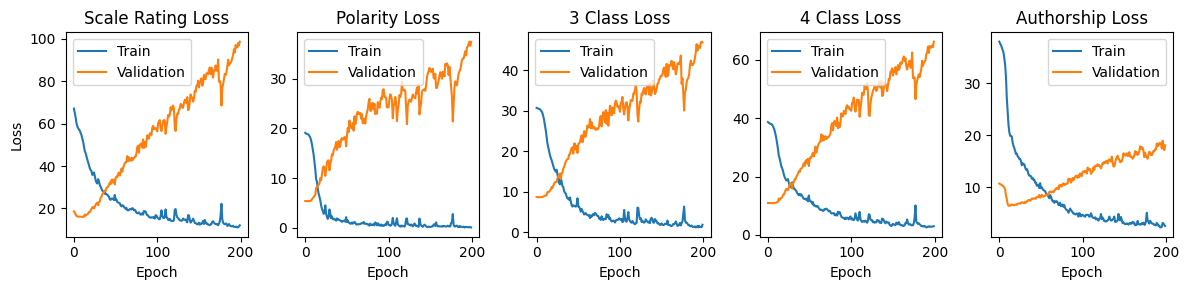

In [15]:
fig, axs = plt.subplots(ncols=5,figsize=(12,3))
axs[0].set_title('Scale Rating Loss')
axs[0].plot([i for i in range(n_epochs)], train_loss1,label='Train')
axs[0].plot([i for i in range(n_epochs)], val_loss1,label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].set_title('Polarity Loss')
axs[1].plot([i for i in range(n_epochs)], train_loss2,label='Train')
axs[1].plot([i for i in range(n_epochs)], val_loss2,label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].legend()
axs[2].set_title('3 Class Loss')
axs[2].plot([i for i in range(n_epochs)], train_loss3,label='Train')
axs[2].plot([i for i in range(n_epochs)], val_loss3,label='Validation')
axs[2].set_xlabel('Epoch')
axs[2].legend()
axs[3].set_title('4 Class Loss')
axs[3].plot([i for i in range(n_epochs)], train_loss4,label='Train')
axs[3].plot([i for i in range(n_epochs)], val_loss4,label='Validation')
axs[3].set_xlabel('Epoch')
axs[3].legend()
axs[4].set_title('Authorship Loss')
axs[4].plot([i for i in range(n_epochs)], train_loss5,label='Train')
axs[4].plot([i for i in range(n_epochs)], val_loss5,label='Validation')
axs[4].set_xlabel('Epoch')
axs[4].legend()
plt.tight_layout()
plt.show()
plt.close()

Accuracy

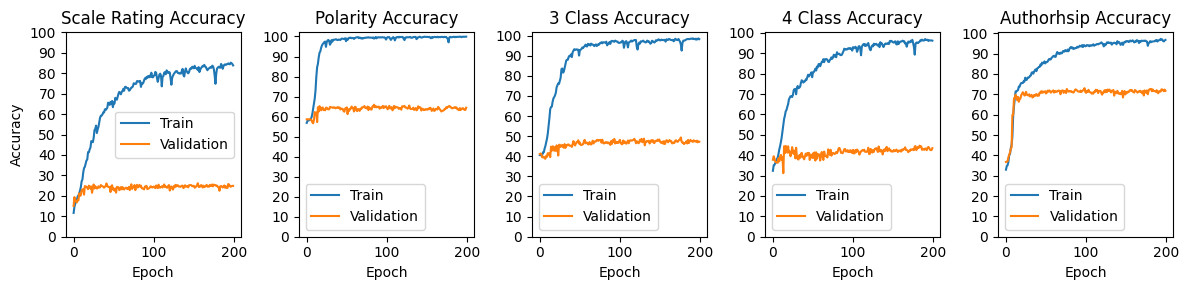

In [16]:
fig, axs = plt.subplots(ncols=5,figsize=(12,3))
axs[0].set_title('Scale Rating Accuracy')
axs[0].plot([i for i in range(n_epochs)], train_acc1, label='Train')
axs[0].plot([i for i in range(n_epochs)], val_acc1, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_yticks(np.arange(0,110,10))
axs[0].legend()

axs[1].set_title('Polarity Accuracy')
axs[1].plot([i for i in range(n_epochs)], train_acc2, label='Train')
axs[1].plot([i for i in range(n_epochs)], val_acc2, label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_yticks(np.arange(0,110,10))
axs[1].legend()

axs[2].set_title('3 Class Accuracy')
axs[2].plot([i for i in range(n_epochs)], train_acc3, label='Train')
axs[2].plot([i for i in range(n_epochs)], val_acc3, label='Validation')
axs[2].set_xlabel('Epoch')
axs[2].set_yticks(np.arange(0,110,10))
axs[2].legend()

axs[3].set_title('4 Class Accuracy')
axs[3].plot([i for i in range(n_epochs)], train_acc4, label='Train')
axs[3].plot([i for i in range(n_epochs)], val_acc4, label='Validation')
axs[3].set_xlabel('Epoch')
axs[3].set_yticks(np.arange(0,110,10))
axs[3].legend()

axs[4].set_title('Authorhsip Accuracy')
axs[4].plot([i for i in range(n_epochs)], train_acc5, label='Train')
axs[4].plot([i for i in range(n_epochs)], val_acc5, label='Validation')
axs[4].set_xlabel('Epoch')
axs[4].set_yticks(np.arange(0,110,10))
axs[4].legend()

plt.tight_layout()
plt.show()
plt.close()

Get Validation Predictions

In [17]:
# Validate
with torch.no_grad():
    model.eval()

    i=0
    for (text1, labels1), (text2, labels2), (text3, labels3), (text4, labels4), (text5, labels5) in zip(val_loader1, val_loader2, val_loader3, val_loader4, val_loader5):

        text1, labels1 = text1.T.to(device), labels1.to(device)
        text2, labels2 = text2.T.to(device), labels2.to(device)
        text3, labels3 = text3.T.to(device), labels3.to(device)
        text4, labels4 = text4.T.to(device), labels4.to(device)
        text5, labels5 = text5.T.to(device), labels5.to(device)

        # Predict scale rating
        pred1 = model(text1, task_id = 0)
        loss1 = criterion1(pred1, labels1)

        # Predict Polarity
        pred2 = model(text2, task_id = 1)
        loss2 = criterion2(pred2, labels2)

        # Predict 3 class
        pred3 = model(text3, task_id = 2)
        loss3 = criterion3(pred3, labels3)

        # Predict 4 class
        pred4 = model(text4, task_id = 3)
        loss4 = criterion4(pred4, labels4)

        # Predict authorship
        pred5 = model(text5, task_id = 4)
        loss5 = criterion5(pred5, labels5)

        epoch_loss_val1 += loss1.item()
        epoch_loss_val2 += loss2.item()
        epoch_loss_val3 += loss3.item()
        epoch_loss_val4 += loss4.item()
        epoch_loss_val5 += loss5.item()

        # Calculate accuracy for current batch
        pred1 = pred1.argmax(dim=1)
        pred2 = pred2.argmax(dim=1)
        pred3 = pred3.argmax(dim=1)
        pred4 = pred4.argmax(dim=1)
        pred5 = pred5.argmax(dim=1)

        if i == 0:
            all_pred1 = pred1.cpu().detach().numpy()
            all_labels1 = labels1.cpu().detach().numpy()

            all_pred2 = pred2.cpu().detach().numpy()
            all_labels2 = labels2.cpu().detach().numpy()

            all_pred3 = pred3.cpu().detach().numpy()
            all_labels3 = labels3.cpu().detach().numpy()

            all_pred4 = pred4.cpu().detach().numpy()
            all_labels4 = labels4.cpu().detach().numpy()

            all_pred5 = pred5.cpu().detach().numpy()
            all_labels5 = labels5.cpu().detach().numpy()
            i += 1
        else:
            all_pred1 = np.concatenate([all_pred1, pred1.cpu().detach().numpy()])
            all_labels1 = np.concatenate([all_labels1, labels1.cpu().detach().numpy()])

            all_pred2 = np.concatenate([all_pred2, pred2.cpu().detach().numpy()])
            all_labels2 = np.concatenate([all_labels2, labels2.cpu().detach().numpy()])

            all_pred3 = np.concatenate([all_pred3, pred3.cpu().detach().numpy()])
            all_labels3 = np.concatenate([all_labels3, labels3.cpu().detach().numpy()])

            all_pred4 = np.concatenate([all_pred4, pred4.cpu().detach().numpy()])
            all_labels4 = np.concatenate([all_labels4, labels4.cpu().detach().numpy()])

            all_pred5 = np.concatenate([all_pred5, pred5.cpu().detach().numpy()])
            all_labels5 = np.concatenate([all_labels5, labels5.cpu().detach().numpy()])

        del text1, labels1, text2, labels2, text3, labels3, text4, labels4, text5, labels5,
        del pred1, pred2, pred3, pred4, pred5, loss1, loss2, loss3, loss4, loss5

Confusion Matrix

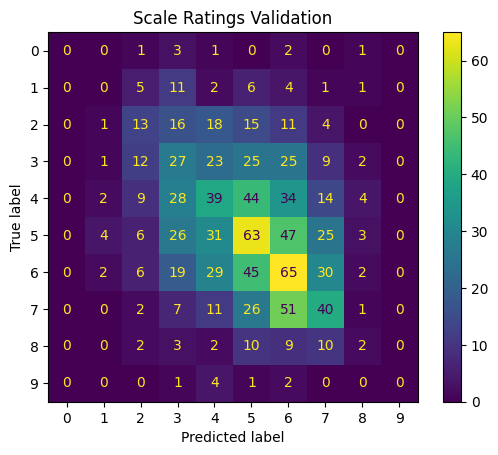

In [18]:
cm = confusion_matrix(all_labels1, all_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Scale Ratings Validation")
plt.show()

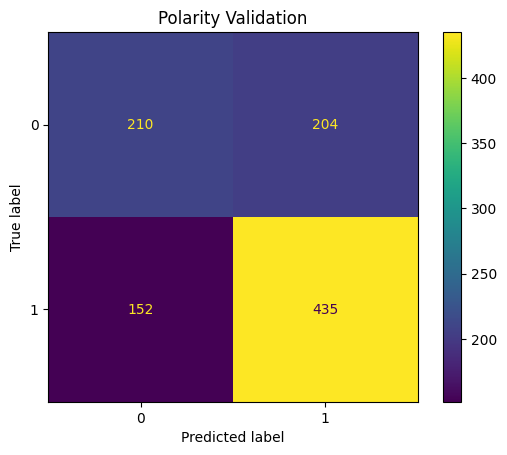

In [19]:
cm = confusion_matrix(all_labels2, all_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Polarity Validation")
plt.show()

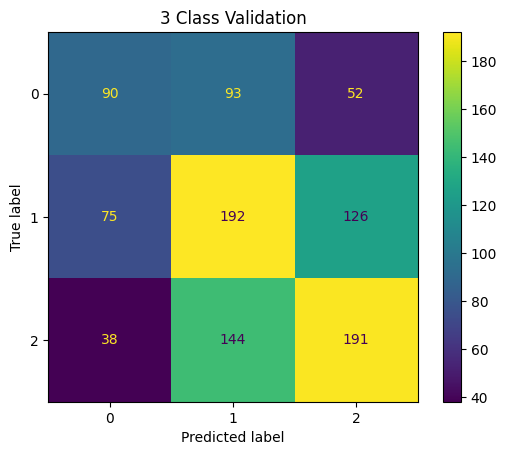

In [20]:
cm = confusion_matrix(all_labels3, all_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("3 Class Validation")
plt.show()

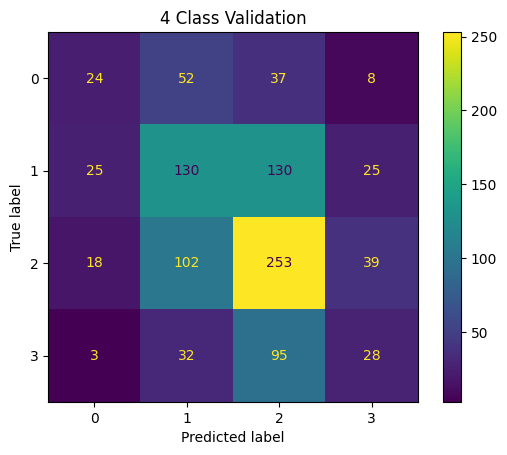

In [21]:
cm = confusion_matrix(all_labels4, all_pred4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("4 Class Validation")
plt.show()

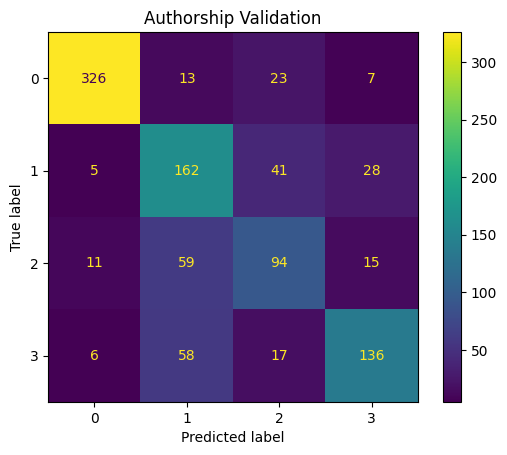

In [22]:
cm = confusion_matrix(all_labels5, all_pred5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Authorship Validation")
plt.show()

In [23]:
f1 = f1_score(all_labels1, all_pred1, average = 'weighted')
f1_2 = f1_score(all_labels2, all_pred2, average = 'weighted')
f1_3 = f1_score(all_labels3, all_pred3, average = 'weighted')
f1_4 = f1_score(all_labels4, all_pred4, average = 'weighted')
f1_5 = f1_score(all_labels5, all_pred5, average = 'weighted')
print(f"F1 score for Scale Rating: {f1}")
print(f"F1 score for Polarity: {f1_2}")
print(f"F1 score for 3 Class Ratings: {f1_3}")
print(f"F1 score for 4 Class Ratings: {f1_4}")
print(f"F1 score for Authorship: {f1_5}")

F1 score for Scale Rating: 0.24050919901870552
F1 score for Polarity: 0.6399819383119362
F1 score for 3 Class Ratings: 0.4717245084289242
F1 score for 4 Class Ratings: 0.4179279052006735
F1 score for Authorship: 0.7211688155116757


## Get final test results

In [38]:
for i in range(test.shape[0]):
    review = test['Review'].iloc[i]
    words = review.split('.')
    review = ' . <start>'.join(words)
    review = ''.join(['<start> '] + [review])

    if '!' in review:
        words = review.split('!')
        review = ' ! <start>'.join(words)
    if '?' in review:
        words = review.split('?')
        review = ' ? <start>'.join(words)

    test['Review'].iloc[i] = review

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test['Review'].iloc[i] = review
<ipython-input-38-a77be1b26ecf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Review'].iloc[i] = review
<ipython-input-38-a77be1b26ecf>:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are se

In [39]:
x_train, x_test, vocab = tokenize(train['Review'],test['Review'])

500 500


In [29]:
test['Author'] = test['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,
                                         'Scott+Renshaw':2,'Dennis+Schwartz':3})

<ipython-input-29-0598ecf2f3c8>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Author'] = test['Author'].replace({'Steve+Rhodes':0,'James+Berardinelli':1,


In [40]:
# create Tensor datasets
test_data1 = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(test['Rating'].values))
test_data2 = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(test['Polarity'].values))
test_data3 = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(test['Class3'].values))
test_data4 = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(test['Class4'].values))
test_data5 = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(test['Author'].values))

batch_size = 128

# dataloaders
test_loader1 = DataLoader(test_data1, shuffle=False, batch_size=batch_size)
test_loader2 = DataLoader(test_data2, shuffle=False, batch_size=batch_size)
test_loader3 = DataLoader(test_data3, shuffle=False, batch_size=batch_size)
test_loader4 = DataLoader(test_data4, shuffle=False, batch_size=batch_size)
test_loader5 = DataLoader(test_data5, shuffle=False, batch_size=batch_size)

In [41]:
# Validate
with torch.no_grad():
    model.eval()

    i=0
    for (text1, labels1), (text2, labels2), (text3, labels3), (text4, labels4), (text5, labels5) in zip(test_loader1, test_loader2, test_loader3, test_loader4, test_loader5):

        text1, labels1 = text1.T.to(device), labels1.to(device)
        text2, labels2 = text2.T.to(device), labels2.to(device)
        text3, labels3 = text3.T.to(device), labels3.to(device)
        text4, labels4 = text4.T.to(device), labels4.to(device)
        text5, labels5 = text5.T.to(device), labels5.to(device)

        # Predict scale rating
        pred1 = model(text1, task_id = 0)
        #loss1 = criterion1(pred1, labels1)

        # Predict Polarity
        pred2 = model(text2, task_id = 1)
        #loss2 = criterion2(pred2, labels2)

        # Predict 3 class
        pred3 = model(text3, task_id = 2)
        #loss3 = criterion3(pred3, labels3)

        # Predict 4 class
        pred4 = model(text4, task_id = 3)
        #loss4 = criterion4(pred4, labels4)

        # Predict authorship
        pred5 = model(text5, task_id = 4)
        #loss5 = criterion5(pred5, labels5)

        #epoch_loss_test1 += loss1.item()
        #epoch_loss_test2 += loss2.item()
        #epoch_loss_test3 += loss3.item()
        #epoch_loss_test4 += loss4.item()
        #epoch_loss_test5 += loss5.item()

        # Calculate accuracy for current batch
        pred1 = pred1.argmax(dim=1)
        pred2 = pred2.argmax(dim=1)
        pred3 = pred3.argmax(dim=1)
        pred4 = pred4.argmax(dim=1)
        pred5 = pred5.argmax(dim=1)

        if i == 0:
            all_pred1 = pred1.cpu().detach().numpy()
            all_labels1 = labels1.cpu().detach().numpy()

            all_pred2 = pred2.cpu().detach().numpy()
            all_labels2 = labels2.cpu().detach().numpy()

            all_pred3 = pred3.cpu().detach().numpy()
            all_labels3 = labels3.cpu().detach().numpy()

            all_pred4 = pred4.cpu().detach().numpy()
            all_labels4 = labels4.cpu().detach().numpy()

            all_pred5 = pred5.cpu().detach().numpy()
            all_labels5 = labels5.cpu().detach().numpy()
            i += 1
        else:
            all_pred1 = np.concatenate([all_pred1, pred1.cpu().detach().numpy()])
            all_labels1 = np.concatenate([all_labels1, labels1.cpu().detach().numpy()])

            all_pred2 = np.concatenate([all_pred2, pred2.cpu().detach().numpy()])
            all_labels2 = np.concatenate([all_labels2, labels2.cpu().detach().numpy()])

            all_pred3 = np.concatenate([all_pred3, pred3.cpu().detach().numpy()])
            all_labels3 = np.concatenate([all_labels3, labels3.cpu().detach().numpy()])

            all_pred4 = np.concatenate([all_pred4, pred4.cpu().detach().numpy()])
            all_labels4 = np.concatenate([all_labels4, labels4.cpu().detach().numpy()])

            all_pred5 = np.concatenate([all_pred5, pred5.cpu().detach().numpy()])
            all_labels5 = np.concatenate([all_labels5, labels5.cpu().detach().numpy()])

        del text1, labels1, text2, labels2, text3, labels3, text4, labels4, text5, labels5,
        del pred1, pred2, pred3, pred4, pred5#, loss1, loss2, loss3, loss4, loss5

Test Confusion Matrices

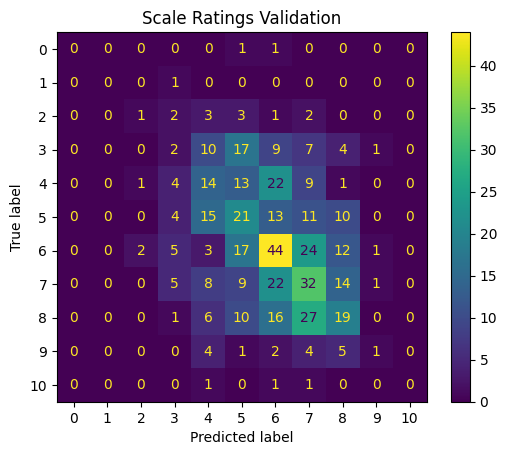

In [42]:
cm = confusion_matrix(all_labels1, all_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Scale Ratings Validation")
plt.show()

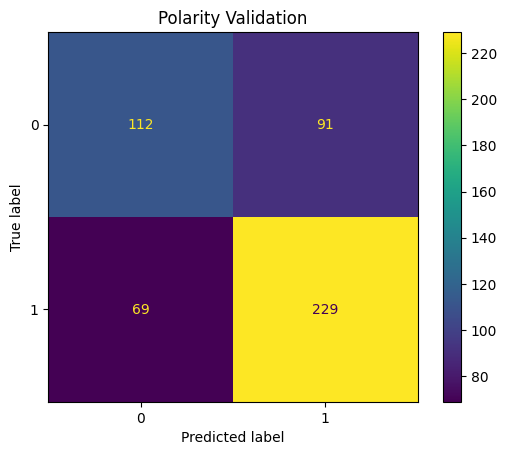

In [43]:
cm = confusion_matrix(all_labels2, all_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Polarity Validation")
plt.show()

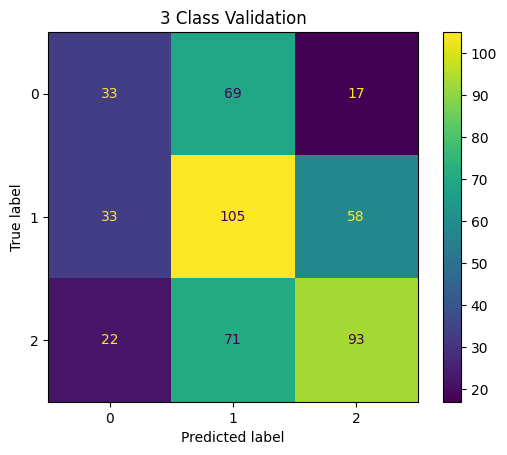

In [44]:
cm = confusion_matrix(all_labels3, all_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("3 Class Validation")
plt.show()

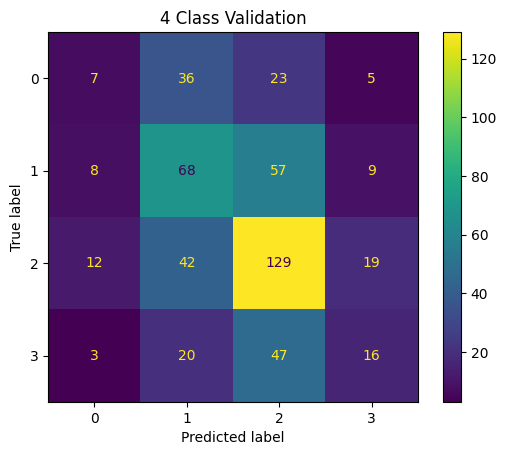

In [45]:
cm = confusion_matrix(all_labels4, all_pred4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("4 Class Validation")
plt.show()

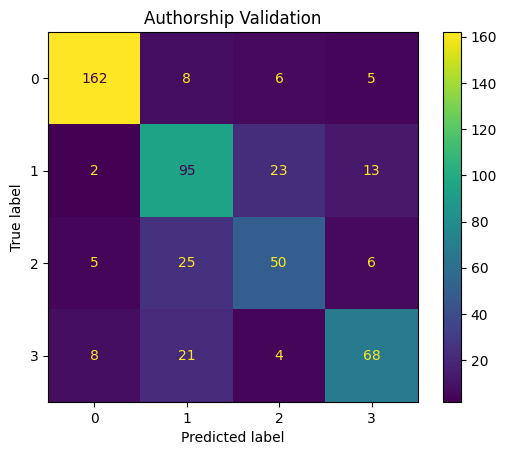

In [46]:
cm = confusion_matrix(all_labels5, all_pred5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Authorship Validation")
plt.show()

Test F1 scores

In [47]:
f1 = f1_score(all_labels1, all_pred1, average = 'weighted')
f1_2 = f1_score(all_labels2, all_pred2, average = 'weighted')
f1_3 = f1_score(all_labels3, all_pred3, average = 'weighted')
f1_4 = f1_score(all_labels4, all_pred4, average = 'weighted')
f1_5 = f1_score(all_labels5, all_pred5, average = 'weighted')
print(f"F1 score for Scale Rating: {f1}")
print(f"F1 score for Polarity: {f1_2}")
print(f"F1 score for 3 Class Ratings: {f1_3}")
print(f"F1 score for 4 Class Ratings: {f1_4}")
print(f"F1 score for Authorship: {f1_5}")

F1 score for Scale Rating: 0.253807493985642
F1 score for Polarity: 0.6771747766602717
F1 score for 3 Class Ratings: 0.4570941634294663
F1 score for 4 Class Ratings: 0.4126116987185632
F1 score for Authorship: 0.7494581703880071
